In [4]:
import pandas as pd

df = pd.read_csv("melbourne_2018-02-12.csv",header=None)
df.columns = ["day","interval","detid","flow","occ","error","city","speed"]
# Convert seconds to hours and minutes
df['hours'] = df['interval'] // 3600
df['minutes'] = (df['interval'] % 3600) // 60

# Create a new column with time in 'hours:minutes' format
df['time'] = df['hours'].astype(str).str.zfill(2) + ':' + df['minutes'].astype(str).str.zfill(2)
df = df.drop(columns=["interval",'hours','minutes'])
df = df[["day","time","detid","flow","occ","city"]]
df.reset_index(drop=True, inplace=True)
df_detectors = pd.read_csv("detectors_public.csv")
df_detectors = df_detectors[df_detectors["citycode"]=="melbourne"][["detid","lanes","linkid"]]
df = df.merge(df_detectors, on="detid")
df_edges = pd.read_csv("Melbourne Edges.csv")
df = df.merge(df_edges, on="linkid")
df["real_flow"] = df["flow"]*df["lanes"]
df

day   time     detid  flow  occ       city  lanes  linkid  \
0      2018-02-12  00:00  K1036.D1    16  NaN  melbourne    1.0   692.0   
1      2018-02-12  00:15  K1036.D1    20  NaN  melbourne    1.0   692.0   
2      2018-02-12  00:30  K1036.D1     4  NaN  melbourne    1.0   692.0   
3      2018-02-12  00:45  K1036.D1     8  NaN  melbourne    1.0   692.0   
4      2018-02-12  01:00  K1036.D1    12  NaN  melbourne    1.0   692.0   
...           ...    ...       ...   ...  ...        ...    ...     ...   
91408  2018-02-12  22:45  K4923.D3    44  NaN  melbourne    1.0   919.0   
91409  2018-02-12  23:00  K4923.D3    48  NaN  melbourne    1.0   919.0   
91410  2018-02-12  23:15  K4923.D3    40  NaN  melbourne    1.0   919.0   
91411  2018-02-12  23:30  K4923.D3    28  NaN  melbourne    1.0   919.0   
91412  2018-02-12  23:45  K4923.D3    24  NaN  melbourne    1.0   919.0   

        cluster  real_flow  
0      [41, 41]       16.0  
1      [41, 41]       20.0  
2      [41, 41]        4.0  
3      [41, 41]        8.0  
4      [41, 41]       12.0  
...         ...        ...  
91408  [16, 13]       44.0  
91409  [16, 13]       48.0  
91410  [16, 13]       40.0  
91411  [16, 13]       28.0  
91412  [16, 13]       24.0  

[91413 rows x 10 columns]

In [5]:
df_2 = pd.read_excel("melbourne_start__SpatialJoin_TableToExcel.xlsx")
df_edges = df_2.groupby("linkid")[["cluster"]].agg(list)
df_nodes = df_2.groupby("cluster")[["long","lat"]].mean()

In [33]:
import networkx as nx
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

def build_graph(nodes,edge_dict):
    internal_nodes_dict = {i:idx for idx,i in enumerate(nodes)}
    internal_edges_dict = {(internal_nodes_dict[edge[0]],internal_nodes_dict[edge[1]]):weight for edge,weight in edge_dict.items()}
    G = nx.DiGraph()
    G.add_nodes_from(internal_nodes_dict.values())
    for edge in internal_edges_dict.keys():
        src, dst = edge
        weight = internal_edges_dict.get((src, dst))
        G.add_edge(src, dst, weight=weight)
    adj_matrix = nx.to_numpy_matrix(G, weight='weight')
    adj_matrix = adj_matrix - adj_matrix.T
    adj_matrix = np.triu(adj_matrix)
    G = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph())
    return G, internal_nodes_dict

def build_graph_2(nodes,edge_dict):
    internal_nodes_dict = {i:idx for idx,i in enumerate(nodes)}
    internal_edges_dict = {(internal_nodes_dict[edge[0]],internal_nodes_dict[edge[1]]):weight for edge,weight in edge_dict.items()}
    G = nx.DiGraph()
    G.add_nodes_from(internal_nodes_dict.values())
    for edge in internal_edges_dict.keys():
        src, dst = edge
        weight = internal_edges_dict.get((src, dst))
        G.add_edge(src, dst, weight=weight)
    adj_matrix = nx.to_numpy_matrix(G, weight='weight')
    adj_matrix = adj_matrix - adj_matrix.T
    adj_matrix[adj_matrix < 0] = 0
    G = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph())
    return G, internal_nodes_dict

def build_graph_3(nodes,edge_dict):
    internal_nodes_dict = {i:idx for idx,i in enumerate(nodes)}
    internal_edges_dict = {(internal_nodes_dict[edge[0]+1],internal_nodes_dict[edge[1]+1]):weight for edge,weight in edge_dict.items()}
    G = nx.DiGraph()
    G.add_nodes_from(internal_nodes_dict.values())
    for edge in internal_edges_dict.keys():
        src, dst = edge
        weight = internal_edges_dict.get((src, dst))
        G.add_edge(src, dst, weight=weight)
    adj_matrix = nx.to_numpy_matrix(G, weight='weight')
    adj_matrix = adj_matrix - adj_matrix.T
    adj_matrix[adj_matrix < 0] = 0
    G = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph())
    return G, internal_nodes_dict

def delete_element(lst, i):
    lst.pop(i)
    return lst

def get_k_simplex_by_k_plus_1_simplex_boundary(G,k):
    k_simplicies = [tuple(clique) for clique in nx.enumerate_all_cliques(G.to_undirected()) if len(clique) == k+1]
    k_plus_1_simplicies = [tuple(clique) for clique in nx.enumerate_all_cliques(G.to_undirected()) if len(clique) == k+2]
    k_simplicies_dict = {k_simplex:idx for idx,k_simplex in enumerate(k_simplicies)}
    k_plus_1_simplicies_dict = {k_plus_1_simplex:idx for idx,k_plus_1_simplex in enumerate(k_plus_1_simplicies)}
    data = []
    row_indices = []
    col_indices = []
    for k_plus_1_simplex in k_plus_1_simplicies:
        col_idx = k_plus_1_simplicies_dict[k_plus_1_simplex]
        for i in range(len(k_plus_1_simplex)):
            row_indices.append(k_simplicies_dict[tuple(delete_element(list(k_plus_1_simplex),i))])
            col_indices.append(col_idx)
            data.append((-1)**(i))
    data = np.array(data)
    row_indices = np.array(row_indices)
    col_indices = np.array(col_indices)
    k_simplex_by_k_plus_1_simplex_boundary = csc_matrix((data, (row_indices, col_indices)), shape=(len(k_simplicies), len(k_plus_1_simplicies)))
    return k_simplex_by_k_plus_1_simplex_boundary,k_simplicies,k_plus_1_simplicies

def get_hodge_laplacian(G,k):
    if k == 0:
        k_by_k_plus_1_bdary,k_simplcies,k_plus_1_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k)
        hodge_laplacian = k_by_k_plus_1_bdary@k_by_k_plus_1_bdary.T
    elif k >= 1:
        k_by_k_plus_1_bdary,k_simplcies,k_plus_1_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k)
        k_minus_1_by_k_bdary,k_minus_1_simplcies,k_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k-1)
        hodge_laplacian = k_minus_1_by_k_bdary.T@k_minus_1_by_k_bdary+k_by_k_plus_1_bdary@k_by_k_plus_1_bdary.T
    return hodge_laplacian

def get_graph_laplacian(G):
    return get_hodge_laplacian(G,0)

def get_graph_helmholtzian(G):
    return get_hodge_laplacian(G,1)

def get_vertex_by_edge_boundary(G):
    return get_k_simplex_by_k_plus_1_simplex_boundary(G,0)

def get_edge_by_triangle_boundary(G):
    return get_k_simplex_by_k_plus_1_simplex_boundary(G,1)

def get_graph_hodge_decomposition(nodes,edge_dict):
    G, internal_nodes_dict = build_graph(nodes,edge_dict)
    edge_flows = np.array([data['weight'] for _, _, data in G.edges(data=True)]).T
    vertex_by_edge_boundary,vertices,edges = get_vertex_by_edge_boundary(G)
    edge_by_triangle_boundary,edges,triangles = get_edge_by_triangle_boundary(G)
    graph_laplacian = get_graph_laplacian(G)
    graph_helmholtzian = get_graph_helmholtzian(G)
    vertices_potential = lsqr(vertex_by_edge_boundary.T, edge_flows)[0]
    vertices_potential = vertices_potential-min(vertices_potential)
    gradient_component = vertex_by_edge_boundary.T@vertices_potential
    triangles_curl = lsqr(edge_by_triangle_boundary, edge_flows)[0]
    curl_adjoint_component = edge_by_triangle_boundary@triangles_curl
    graph_helmholtzian_kernel_component = (np.eye(len(edges))-graph_helmholtzian@np.linalg.pinv(graph_helmholtzian.toarray()))@edge_flows
    three_components = (gradient_component,graph_helmholtzian_kernel_component,curl_adjoint_component)
    four_matrices = (vertex_by_edge_boundary,graph_laplacian,graph_helmholtzian,edge_by_triangle_boundary)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    return three_components, four_matrices, (vertices_potential,vertices_divergence,triangles_curl), (vertices,edges,triangles), internal_nodes_dict, edge_flows, G



In [32]:
def get_urban_divergence_potential(nodes,edge_dict):
    G, internal_nodes_dict = build_graph(nodes,edge_dict)
    edge_flows = np.array([data['weight'] for _, _, data in G.edges(data=True)]).T
    vertex_by_edge_boundary,vertices,edges = get_vertex_by_edge_boundary(G)
    vertices_potential = lsqr(vertex_by_edge_boundary.T, edge_flows)[0]
    vertices_potential = vertices_potential-min(vertices_potential)
    graph_laplacian = get_graph_laplacian(G)
    vertices_divergence = graph_laplacian@vertices_potential
    return vertices_potential,vertices_divergence,graph_laplacian,edge_flows

def plot_urban_divergence_potential(vertices_potential,vertices_divergence, hour, minute, city, day):
    divergence_potential_df = pd.DataFrame({
            'Divergence': vertices_divergence,
            'Potential': vertices_potential
        })
    vertices_divergence_greater_potential_df = divergence_potential_df[divergence_potential_df["Divergence"]>0]
    vertices_divergence_less_potential_df = divergence_potential_df[divergence_potential_df["Divergence"]<=0]
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_greater_potential_df["Divergence"], vertices_divergence_greater_potential_df["Potential"], color='blue', marker='o',alpha=0.2)
    plt.scatter(vertices_divergence_less_potential_df["Divergence"], vertices_divergence_less_potential_df["Potential"], color='red', marker='o',alpha=0.2)
    plt.title(f"Histogram of {city} Downtown Road Network Divergence and Potential Values {day} {hour}-{minute}")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    # plt.xlim([-30000,30000])
    # plt.ylim([0,60000])
    plt.grid(True)
    plt.show()

In [31]:
def zero_percentage(matrix, threshold=1e-10):
    non_diagonal_entries = matrix[np.where(~np.eye(matrix.shape[0], dtype=bool))]
    non_zero_count = np.count_nonzero(np.abs(non_diagonal_entries) > threshold)
    total_non_diagonal_entries = len(non_diagonal_entries.flatten())
    percentage = (non_zero_count / total_non_diagonal_entries) * 100
    return percentage

def nonzero_nondiagonal(arr, threshold=1e-10):
    diagonal_indices = np.diag_indices_from(arr)
    arr[diagonal_indices] = 0
    arr[np.abs(arr) < threshold] = 0
    flattened = arr.flatten()
    non_zero_non_diagonal = flattened[flattened != 0]
    return non_zero_non_diagonal

def weighted_to_unweighted(G, threshold=0):
    unweighted_G = nx.DiGraph()
    for u, v, w in G.edges(data='weight'):
        if w > threshold:
            unweighted_G.add_edge(u, v)
            unweighted_G[u][v]['weight'] = 1
    return unweighted_G

def get_local_relative_variance(graph_laplacian,vector):
    result = vector.T@graph_laplacian@vector
    return result

In [30]:
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

def color_graph_by_cc(G):
    scc_nodes = list(nx.connected_components(G.to_undirected()))
    color_map = {}
    for i, nodes in enumerate(scc_nodes):
        for node in nodes:
            color_map[node] = i
    plt.figure(figsize=(15,15))
    pos = {index-1:(float(row["long"]),float(row["lat"])) for index, row in df_nodes.iterrows()}
    nx.draw(G, pos, node_color=[color_map[node] for node in G.nodes()], with_labels=False, cmap=plt.cm.tab10, node_size=70)
    plt.title("Graph with Nodes Colored by CC")
    plt.show()

def color_graph_by_scc(G):
    scc_nodes = list(nx.strongly_connected_components(G))
    color_map = {}
    for i, nodes in enumerate(scc_nodes):
        for node in nodes:
            color_map[node] = i
    plt.figure(figsize=(15,15))
    pos = {index-1:(float(row["long"]),float(row["lat"])) for index, row in df_nodes.iterrows()}
    nx.draw(G, pos, node_color=[color_map[node] for node in G.nodes()], with_labels=False, cmap=plt.cm.tab10, node_size=70)
    plt.title("Graph with Nodes Colored by SCC")
    plt.show()

def potential_divergence_map(G, vertices_potential,vertices_divergence,i,j, city, day):
    print("number of connected components: ",nx.number_connected_components(G.to_undirected()))
    print("number of strongly connected components: ",nx.number_strongly_connected_components(G))
    color_graph_by_cc(G)
    # color_graph_by_scc(G)

    plt.figure(figsize=(19,15))
    cmap = plt.cm.viridis
    pos = {index-1:(float(row["long"]),float(row["lat"])) for index, row in df_nodes.iterrows()}
    nx.draw(G, pos, with_labels=False, node_size=150, font_size=12, node_color=vertices_potential, cmap=cmap)
    plt.title(f"{city} Downtown Road Network Negative Potential {day} {i}:{j}")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm._A = []
    plt.colorbar(sm, label='Node Negative Potential')
    plt.show()

    plt.figure(figsize=(19,5))
    plt.hist(vertices_potential, bins=100, color='skyblue')
    plt.xlabel('Negative Potential')
    plt.ylabel('Frequency')
    # plt.xlim([0,50000])
    plt.title(f'Histogram of {city} Downtown Road Network Negative Potential {day} {i}-{j}')
    plt.show()

    cmap_colors = [(0, 'blue'), (-min(vertices_divergence)/(max(vertices_divergence)-min(vertices_divergence)), 'white'), (1, 'red')]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)
    plt.figure(figsize=(19, 15))
    nx.draw(G, pos, with_labels=False, node_size=150, font_size=12, node_color=vertices_divergence, cmap=cmap)
    plt.title(f"{city} Downtown Road Network Divergence {day} {i}:{j}")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm._A = []
    plt.colorbar(sm, label='Node Divergence')
    plt.show()

    plt.figure(figsize=(19,5))
    plt.hist(vertices_divergence, bins=100, color='skyblue')
    plt.xlabel('Divergence')
    plt.ylabel('Frequency')
    # plt.xlim([-25000,40000])
    plt.title(f'Histogram of {city} Downtown Road Network Divergence {day} {i}-{j}')
    plt.show()

In [29]:
def draw_Edge_flow(nodes,edge_dict,edges,edge_flows,gradient_component,graph_helmholtzian_kernel_component,curl_adjoint_component,i,j, city, day):
    G, internal_nodes_dict = build_graph_2(nodes,edge_dict)
    pos = {index-1:(float(row["long"]),float(row["lat"])) for index, row in df_nodes.iterrows()}
    print("Coefficient of determination: ",np.sum(gradient_component**2)/np.sum(edge_flows**2))
    plt.figure(figsize=(19, 15))
    nx.draw_networkx_nodes(G, pos, node_size=1, node_color="black")
    cmap = plt.cm.get_cmap('Reds')
    edge_weights = [G[u][v]['weight'] for u, v in G.edges() if 'weight' in G[u][v]]
    norm = plt.Normalize(min(edge_weights), max(edge_weights))
    edge_colors = [cmap(norm(value)) for value in edge_weights]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Edge Traffic Flow Volume')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, alpha=1)  # Draw edges with colors based on weights
    plt.title(f"{city} Downtown Road Network Road Traffic Flow (Assymmetric) {day} {i}:{j}")
    plt.show()

    edge_dict_1 = {}
    for idx,edge in enumerate(edges):
        edge_dict_1[edge] = gradient_component[idx]
    G, internal_nodes_dict = build_graph_3(nodes,edge_dict_1)
    plt.figure(figsize=(19, 15))
    nx.draw_networkx_nodes(G, pos, node_size=1, node_color="black")
    cmap = plt.cm.get_cmap('Reds')
    edge_weights = [G[u][v]['weight'] for u, v in G.edges() if 'weight' in G[u][v]]
    norm = plt.Normalize(min(edge_weights), max(edge_weights))
    edge_colors = [cmap(norm(value)) for value in edge_weights]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Gradient Edge Traffic Flow Volume')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, alpha=1)  # Draw edges with colors based on weights
    plt.title(f"{city} Downtown Road Network Road Traffic Flow (Gradient) {day} {i}:{j}")
    plt.show()

    edge_dict_1 = {}
    for idx,edge in enumerate(edges):
        edge_dict_1[edge] = graph_helmholtzian_kernel_component[idx]
    G, internal_nodes_dict = build_graph_3(nodes,edge_dict_1)
    plt.figure(figsize=(19, 15))
    nx.draw_networkx_nodes(G, pos, node_size=1, node_color="black")
    cmap = plt.cm.get_cmap('Reds')
    edge_weights = [G[u][v]['weight'] for u, v in G.edges() if 'weight' in G[u][v]]
    norm = plt.Normalize(min(edge_weights), max(edge_weights))
    edge_colors = [cmap(norm(value)) for value in edge_weights]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Harmonic Edge Traffic Flow Volume')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, alpha=1)  # Draw edges with colors based on weights
    plt.title(f"{city} Downtown Road Network Road Traffic Flow (Harmonic) {day} {i}:{j}")
    plt.show()

    edge_dict_1 = {}
    for idx,edge in enumerate(edges):
        edge_dict_1[edge] = curl_adjoint_component[idx]
    G, internal_nodes_dict = build_graph_3(nodes,edge_dict_1)
    plt.figure(figsize=(19, 15))
    nx.draw_networkx_nodes(G, pos, node_size=1, node_color="black")
    cmap = plt.cm.get_cmap('Reds')
    edge_weights = [G[u][v]['weight'] for u, v in G.edges() if 'weight' in G[u][v]]
    norm = plt.Normalize(min(edge_weights), max(edge_weights))
    edge_colors = [cmap(norm(value)) for value in edge_weights]
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Curl Adjoint Edge Traffic Flow Volume')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, alpha=1)  # Draw edges with colors based on weights
    plt.title(f"{city} Downtown Road Network Road Traffic Flow (Curl Adjoint) {day} {i}:{j}")
    plt.show()

In [28]:
def draw_matrix_values(laplacian_matrix, vertices_divergence,i,j,city,day):
    print("Non-zero percentage of Graph Laplacian: ",zero_percentage(laplacian_matrix),"%")
    vertices_divergence = vertices_divergence>0
    values = np.diag(laplacian_matrix)
    values_true = [values[i] for i in range(len(values)) if vertices_divergence[i]]
    values_false = [values[i] for i in range(len(values)) if not vertices_divergence[i]]
    plt.figure(figsize=(15, 8))
    plt.hist(values_true, bins=100, color='blue', alpha=0.5, label='divergence>0')
    plt.hist(values_false, bins=100, color='red', alpha=0.5, label='divergence<0')
    plt.title(f'Histogram of the Diagonal Values of Graph Laplacian (divergence>0 or <0) 2017-10-02 {i}:{j} {city} {day}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    values = np.linalg.eigvals(laplacian_matrix)
    values_true = [values[i] for i in range(len(values)) if vertices_divergence[i]]
    values_false = [values[i] for i in range(len(values)) if not vertices_divergence[i]]
    plt.figure(figsize=(15, 8))
    plt.hist(values_true, bins=100, color='blue', alpha=0.5, label='divergence>0')
    plt.hist(values_false, bins=100, color='red', alpha=0.5, label='divergence<0')
    plt.title(f'Histogram of the Eigen Values of Graph Laplacian (divergence>0 or <0) 2017-10-02 {i}:{j} {city} {day}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    inverse_laplacian_matrix = np.linalg.pinv(laplacian_matrix)
    print("Non-zero percentage of the Inverse of Graph Laplacian: ",zero_percentage(inverse_laplacian_matrix),"%")
    values = np.diag(inverse_laplacian_matrix)
    values_true = [values[i] for i in range(len(values)) if vertices_divergence[i]]
    values_false = [values[i] for i in range(len(values)) if not vertices_divergence[i]]
    plt.figure(figsize=(15, 8))
    plt.hist(values_true, bins=100, color='blue', alpha=0.5, label='divergence>0')
    plt.hist(values_false, bins=100, color='red', alpha=0.5, label='divergence<0')
    plt.title(f'Histogram of the Diagonal Values of the Pseudo Inverse of Graph Laplacian (divergence>0 or <0) 2017-10-02 {i}:{j} {city} {day}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    values = np.linalg.eigvals(inverse_laplacian_matrix)
    values_true = [values[i] for i in range(len(values)) if vertices_divergence[i]]
    values_false = [values[i] for i in range(len(values)) if not vertices_divergence[i]]
    plt.figure(figsize=(15, 8))
    plt.hist(values_true, bins=100, color='blue', alpha=0.5, label='divergence>0')
    plt.hist(values_false, bins=100, color='red', alpha=0.5, label='divergence<0')
    plt.title(f'Histogram of the Eigen Values of the Pseudo Inverse of Graph Laplacian (divergence>0 or <0) 2017-10-02 {i}:{j} {city} {day}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    nonzero_nondiagonal_entries = nonzero_nondiagonal(inverse_laplacian_matrix)
    plt.figure(figsize=(15, 8))
    plt.hist(nonzero_nondiagonal_entries, bins=500, color='blue', alpha=0.5)
    plt.title(f'Histogram of the Non Zero Non Diagonal Values of Pseudo Inverse of Graph Laplacian 2017-10-02 {i}:{j} {city} {day}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


In [35]:
def eigenvalue_gradient_component_map(graph_laplacian,vertex_by_edge_boundary,gradient_component,i,j, city, day):
    G = nx.DiGraph()
    G.add_nodes_from(df_nodes.index)
    G.add_edges_from(df_edges["cluster"])

    eigenvalues, eigenvectors = np.linalg.eig(graph_laplacian)
    U, S, Vt = np.linalg.svd(vertex_by_edge_boundary.T)
    if len(gradient_component)>len(eigenvalues):
        values = list((U.T@gradient_component)**2)[:len(eigenvalues)]
    else:
        eigenvalues = list(eigenvalues)[:len(gradient_component)]
        values = list((U.T@gradient_component)**2)

    print("variance value: ", np.sum(eigenvalues*(np.array(values)**2)))
    plt.figure(figsize=(11,11))
    plt.scatter(eigenvalues,values)
    plt.title(f"{city} Downtown Road Network Graph Laplacian Eigenvalues and Gradient Component {day} {i}:{j}")
    # plt.ylim([0,20000])
    plt.xlabel('Graph Laplacian eigenvalues')
    plt.ylabel('Gradient Component Squared')
    plt.show()

Vertices and Edges Number:  (401, 372)
number of connected components:  45
number of strongly connected components:  401


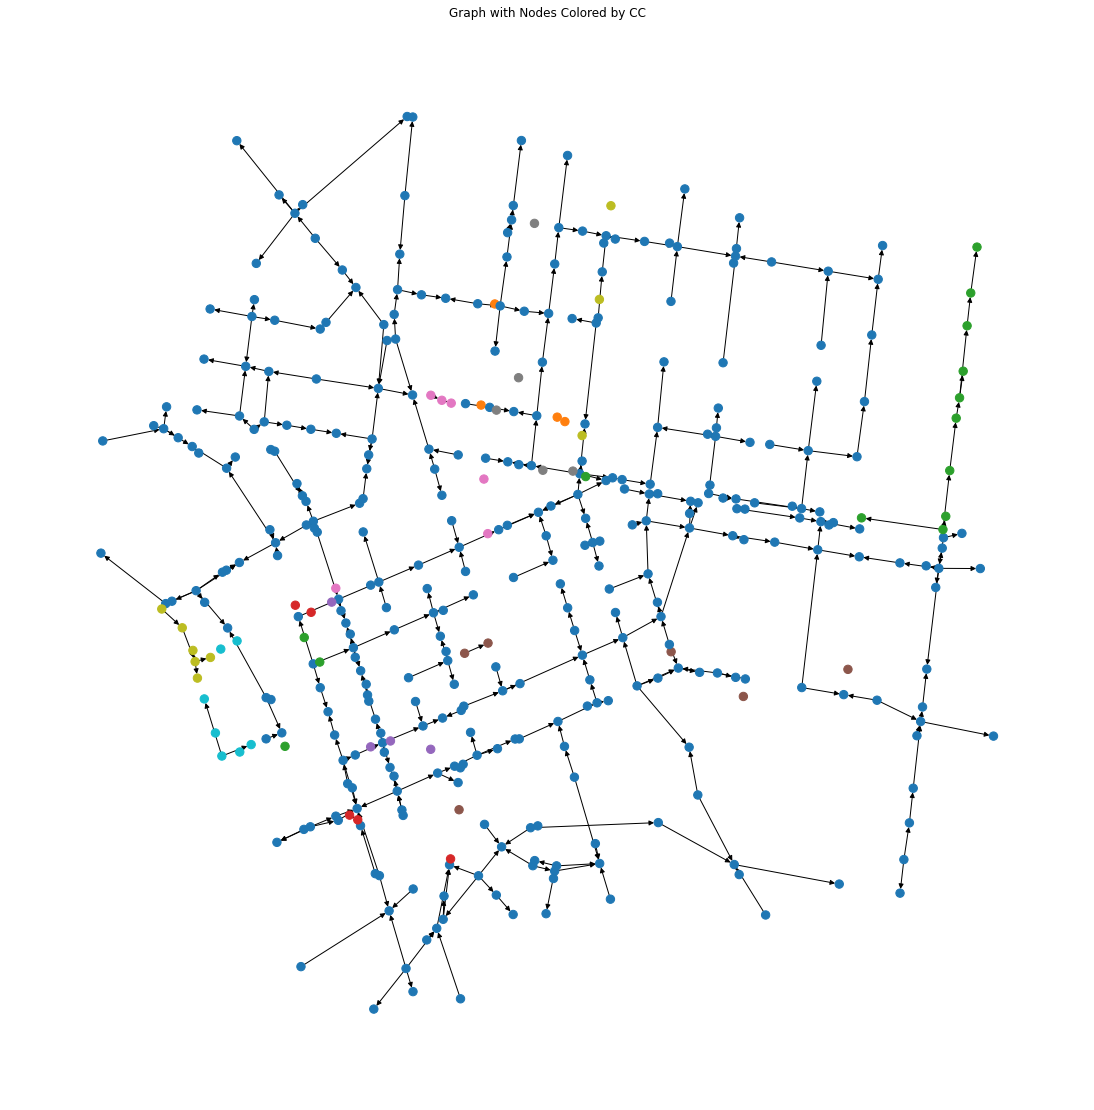

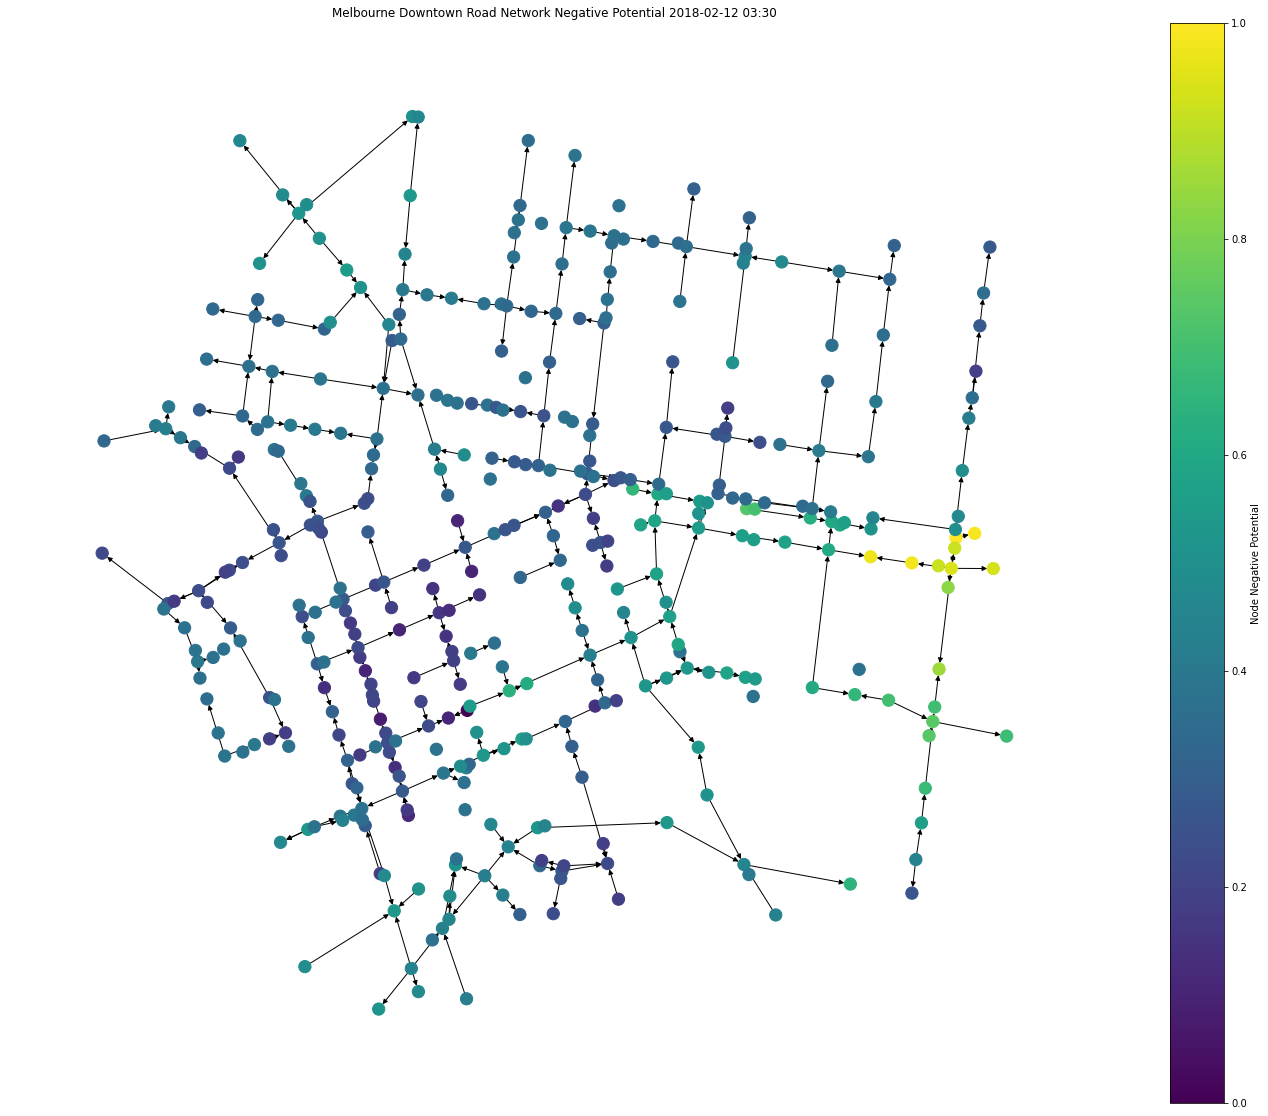

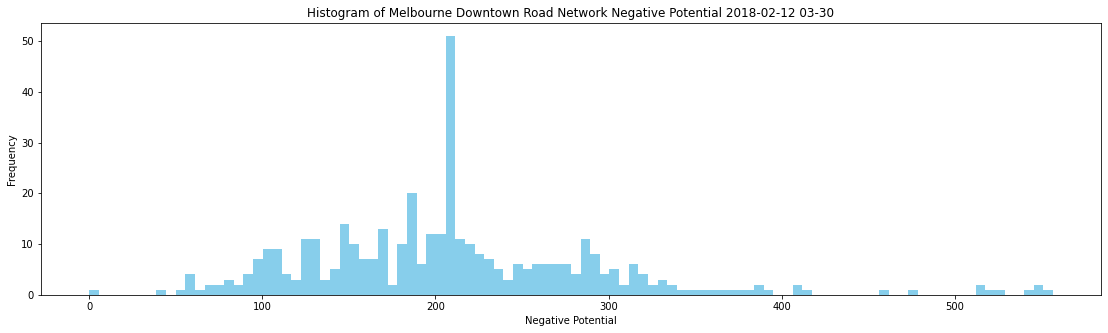

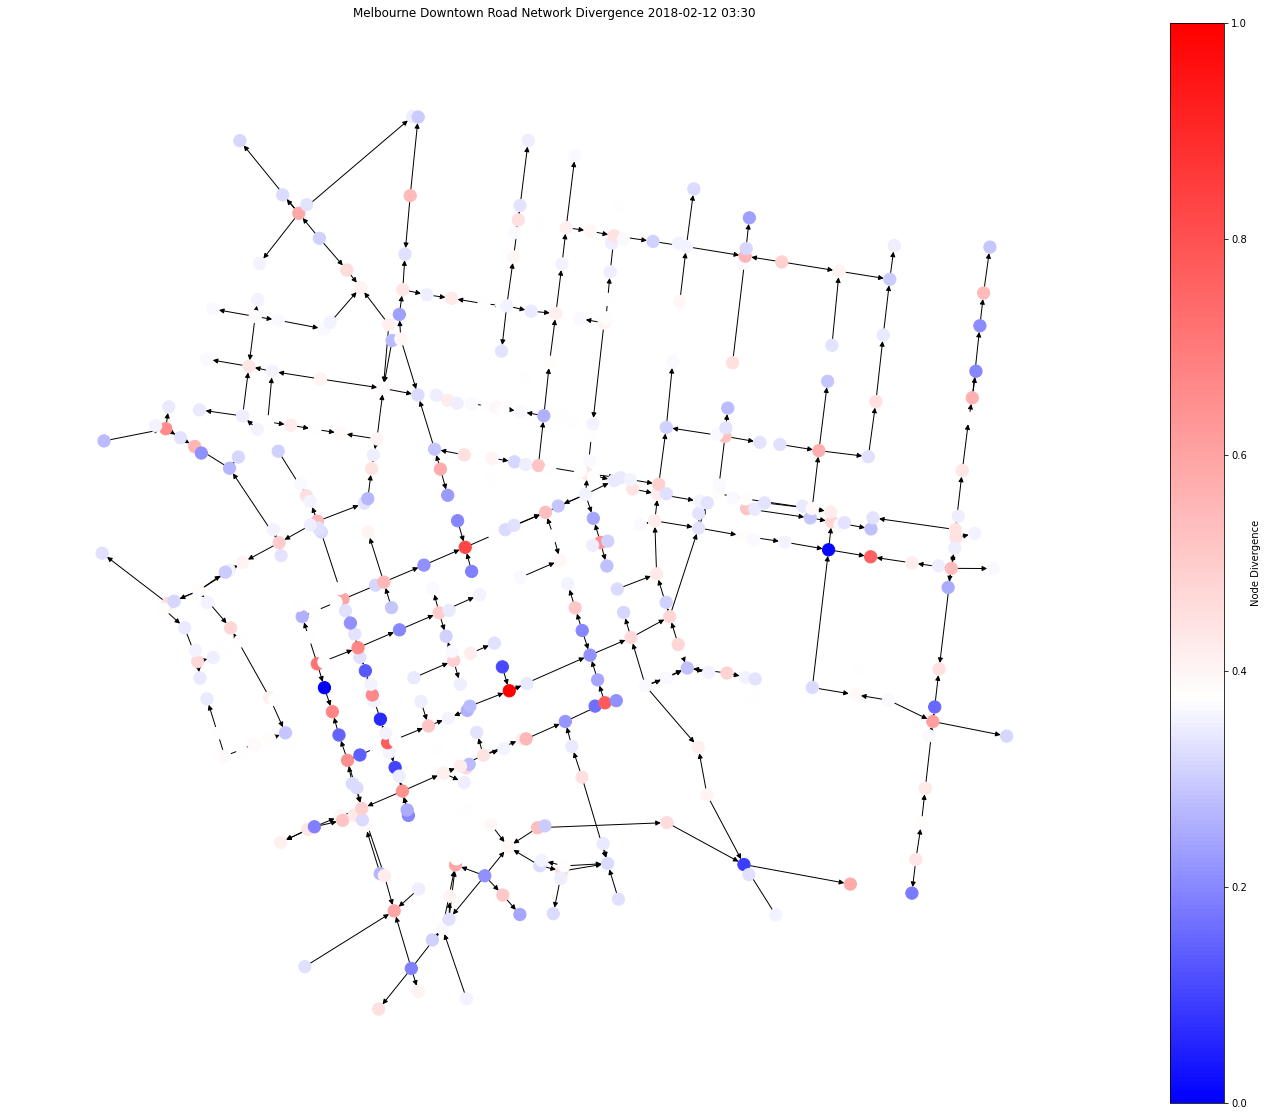

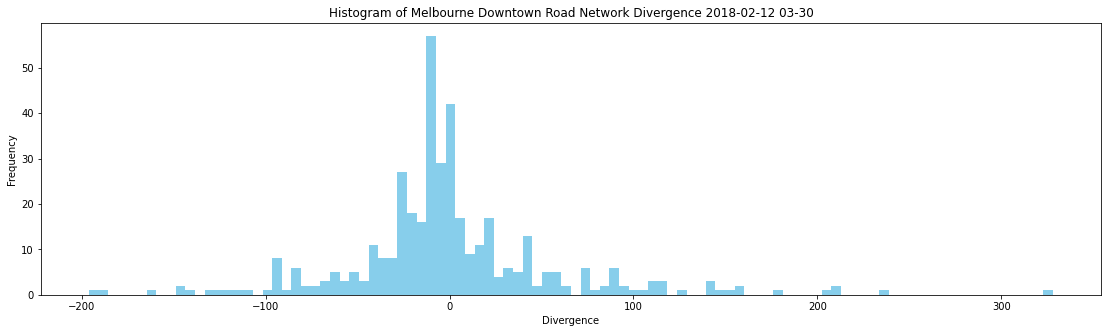

variance value:  (11173899758.365349-2.5311070147902295e-09j)


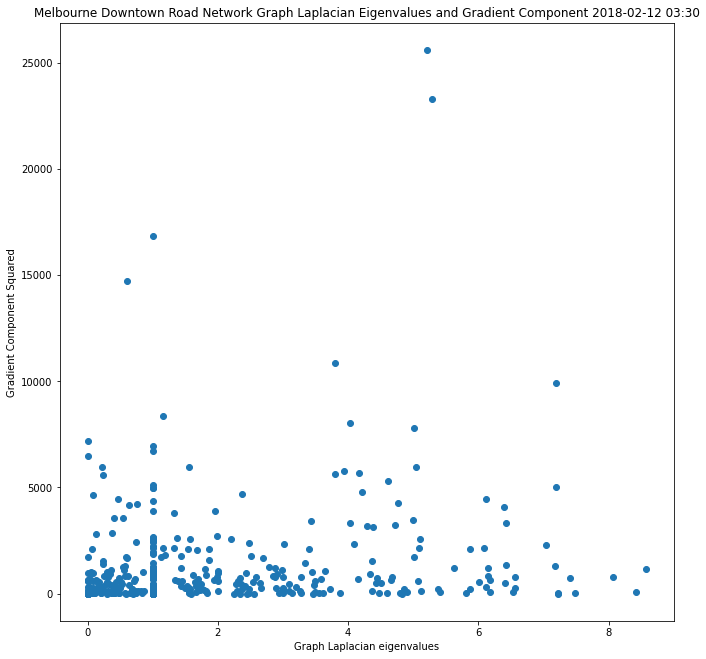

Coefficient of determination:  0.9524061121313133


C:\Users\DELL\AppData\Local\Temp\ipykernel_21644\1049446744.py:15: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, alpha=1)  # Draw edges with colors based on weights


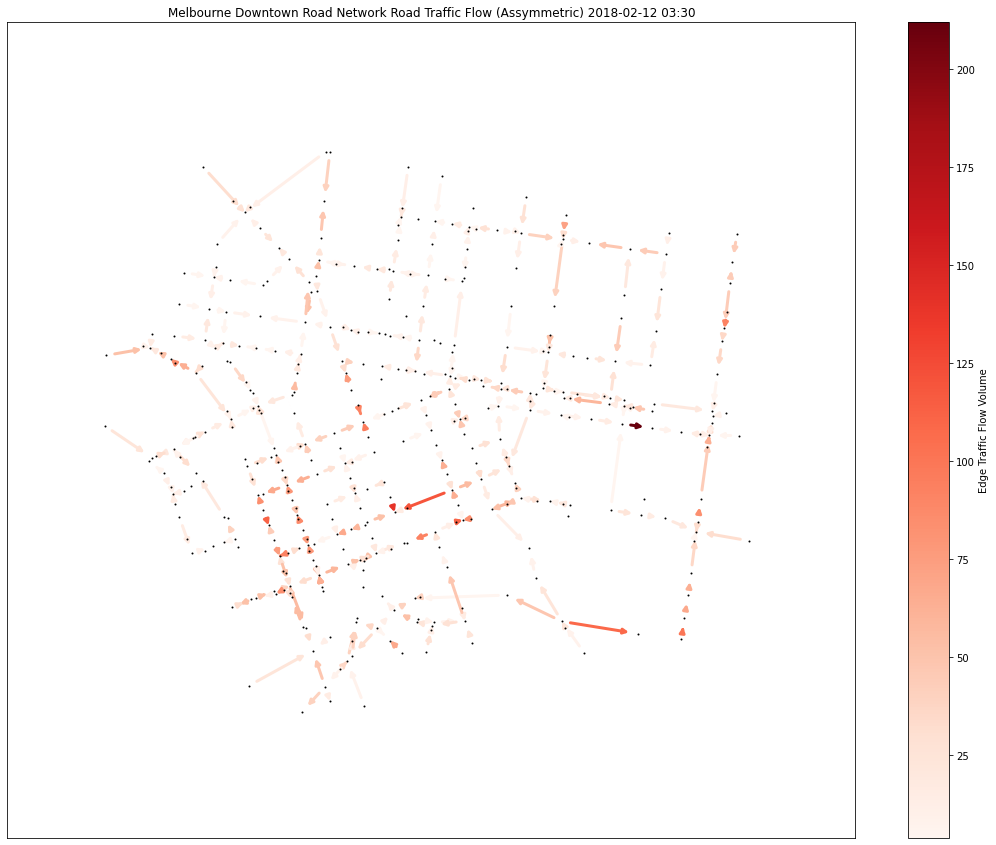

C:\Users\DELL\AppData\Local\Temp\ipykernel_21644\1049446744.py:33: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, alpha=1)  # Draw edges with colors based on weights


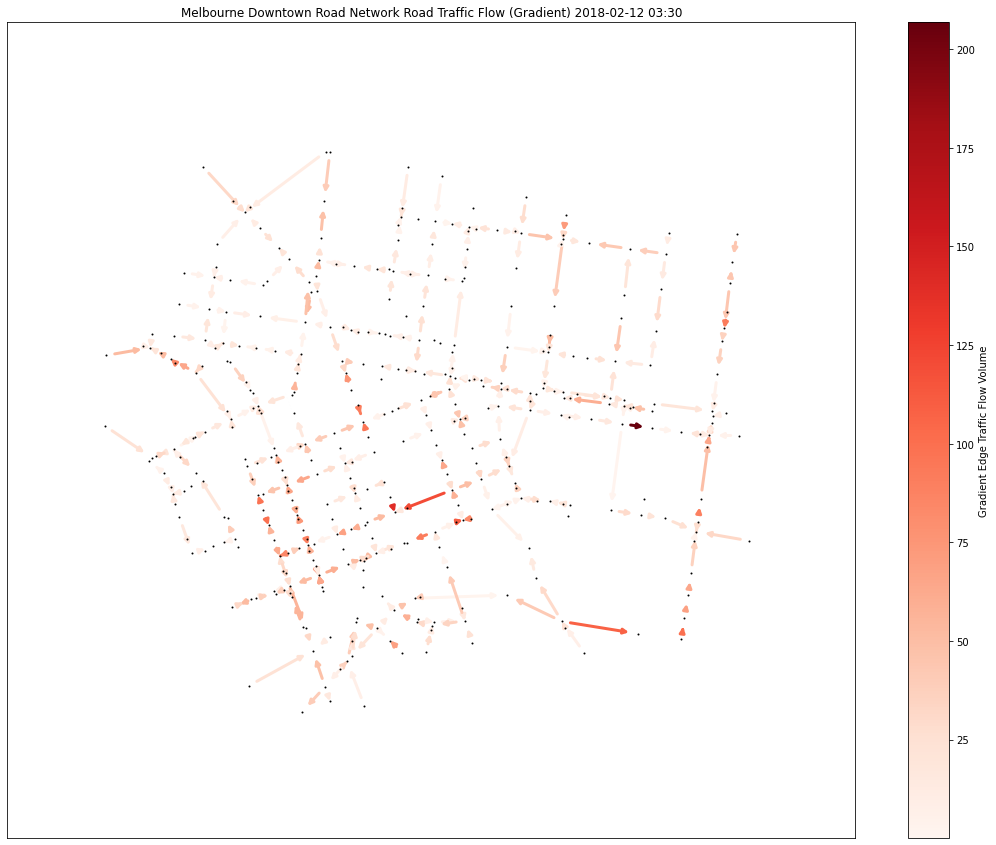

C:\Users\DELL\AppData\Local\Temp\ipykernel_21644\1049446744.py:51: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, alpha=1)  # Draw edges with colors based on weights


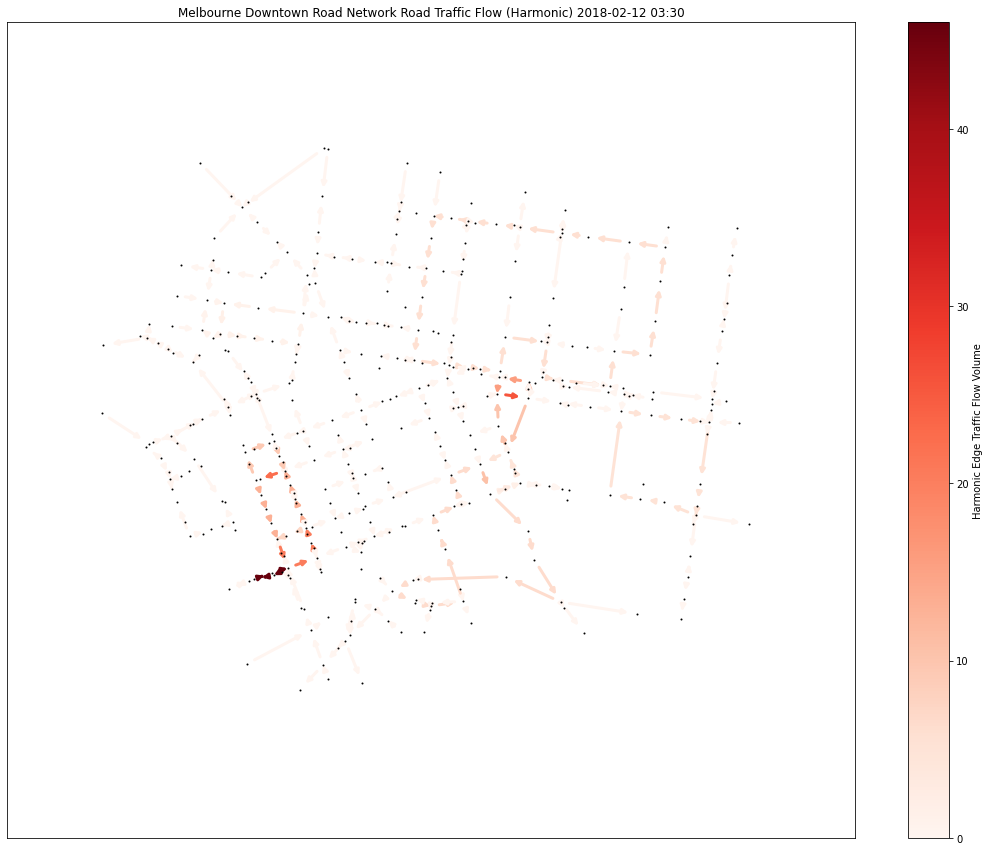

C:\Users\DELL\AppData\Local\Temp\ipykernel_21644\1049446744.py:69: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, alpha=1)  # Draw edges with colors based on weights


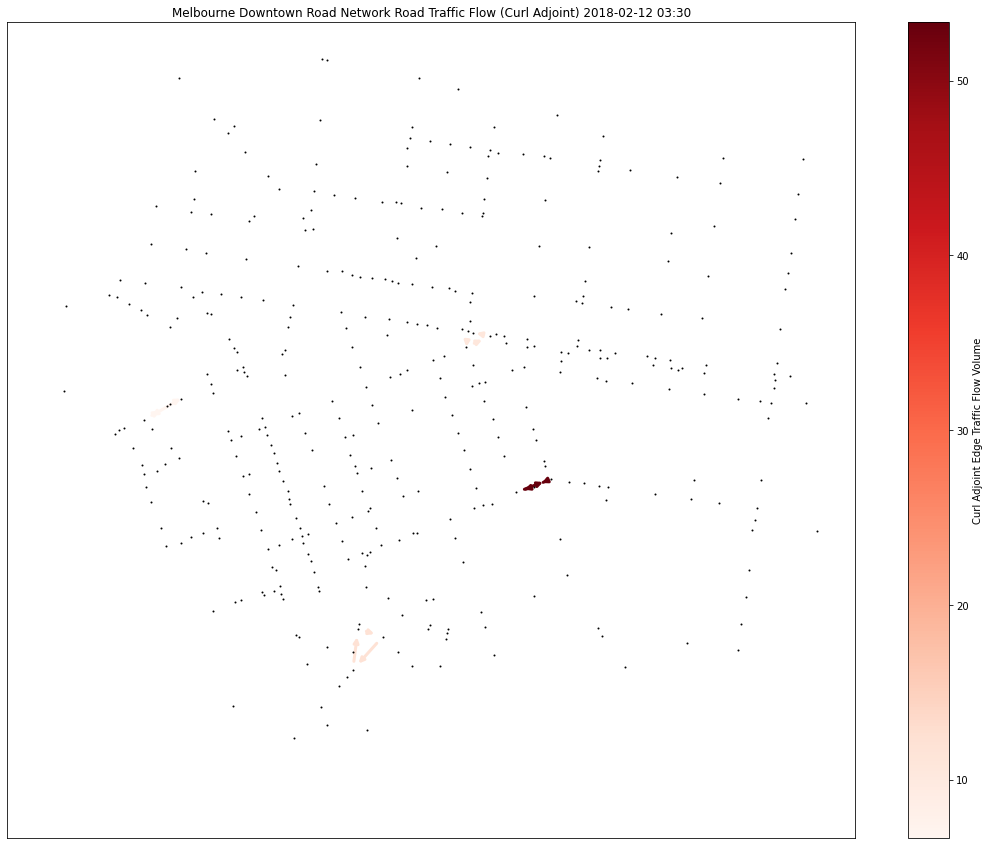

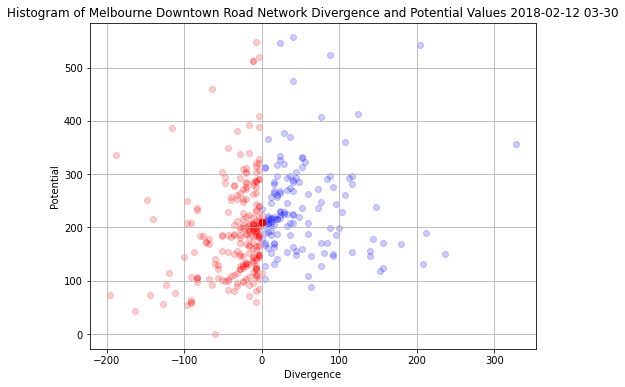

Non-zero percentage of Graph Laplacian:  0.4638403990024938 %


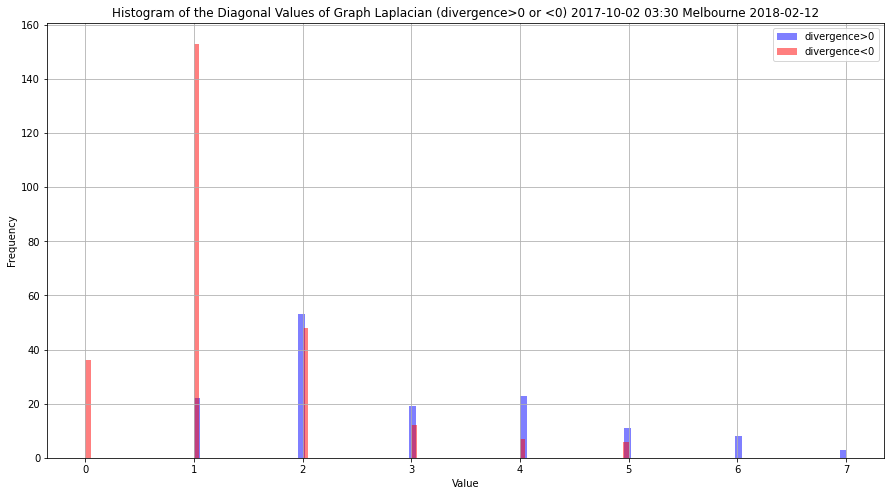

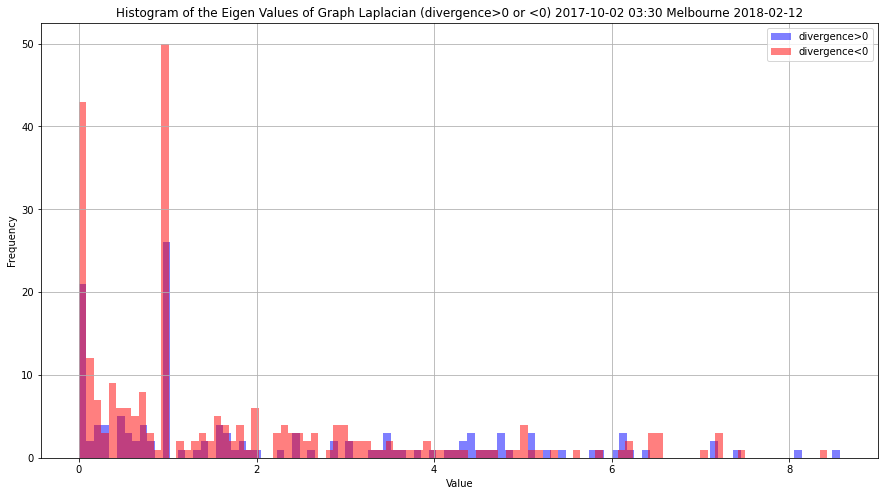

Non-zero percentage of the Inverse of Graph Laplacian:  69.43017456359102 %


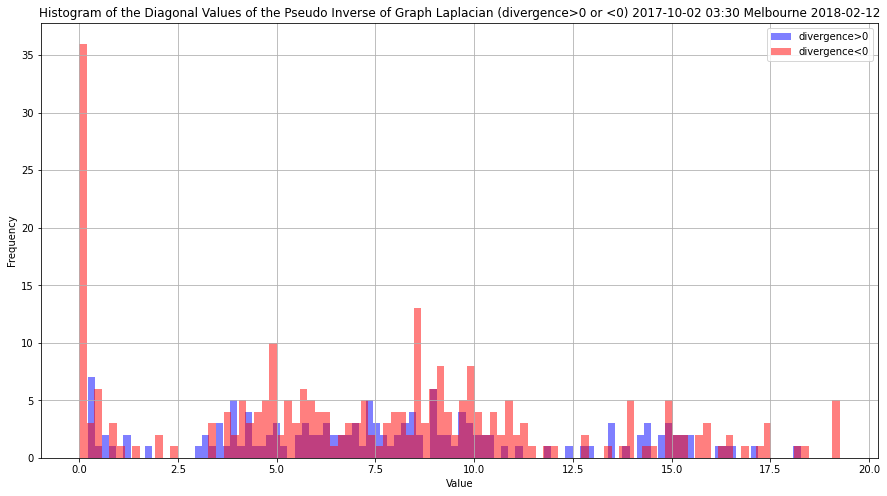

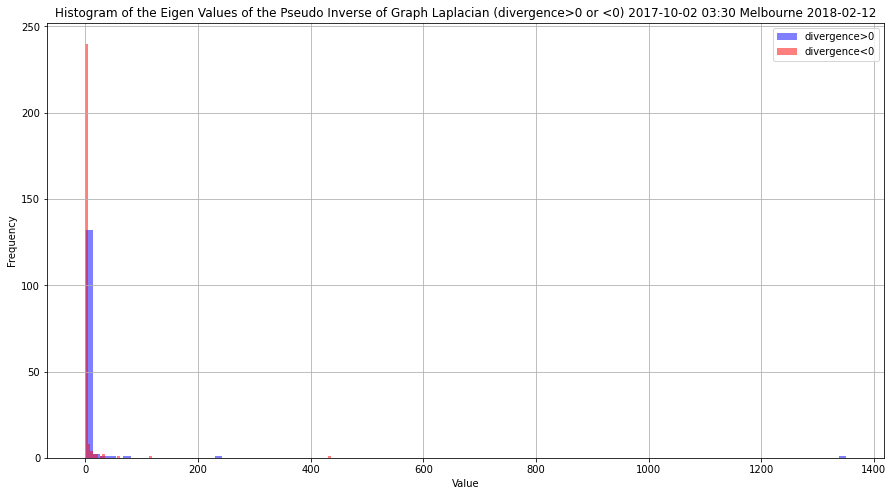

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


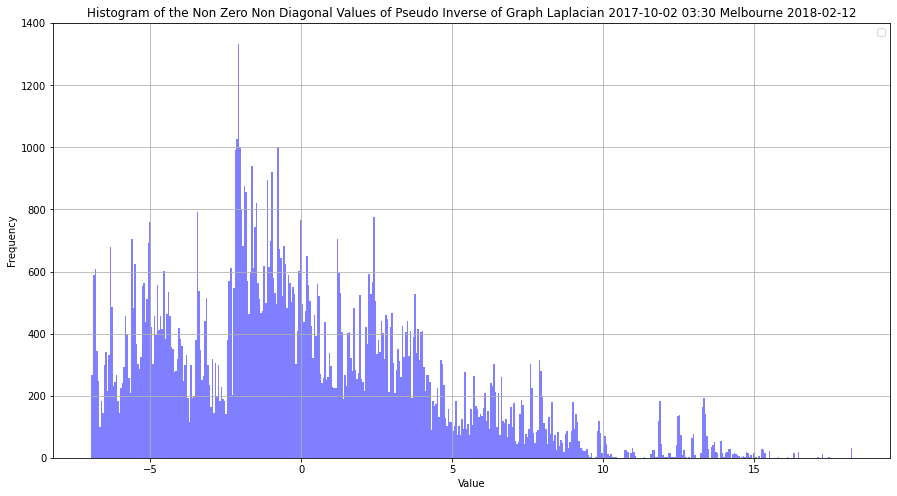

Vertices and Edges Number:  (401, 416)
number of connected components:  21
number of strongly connected components:  401


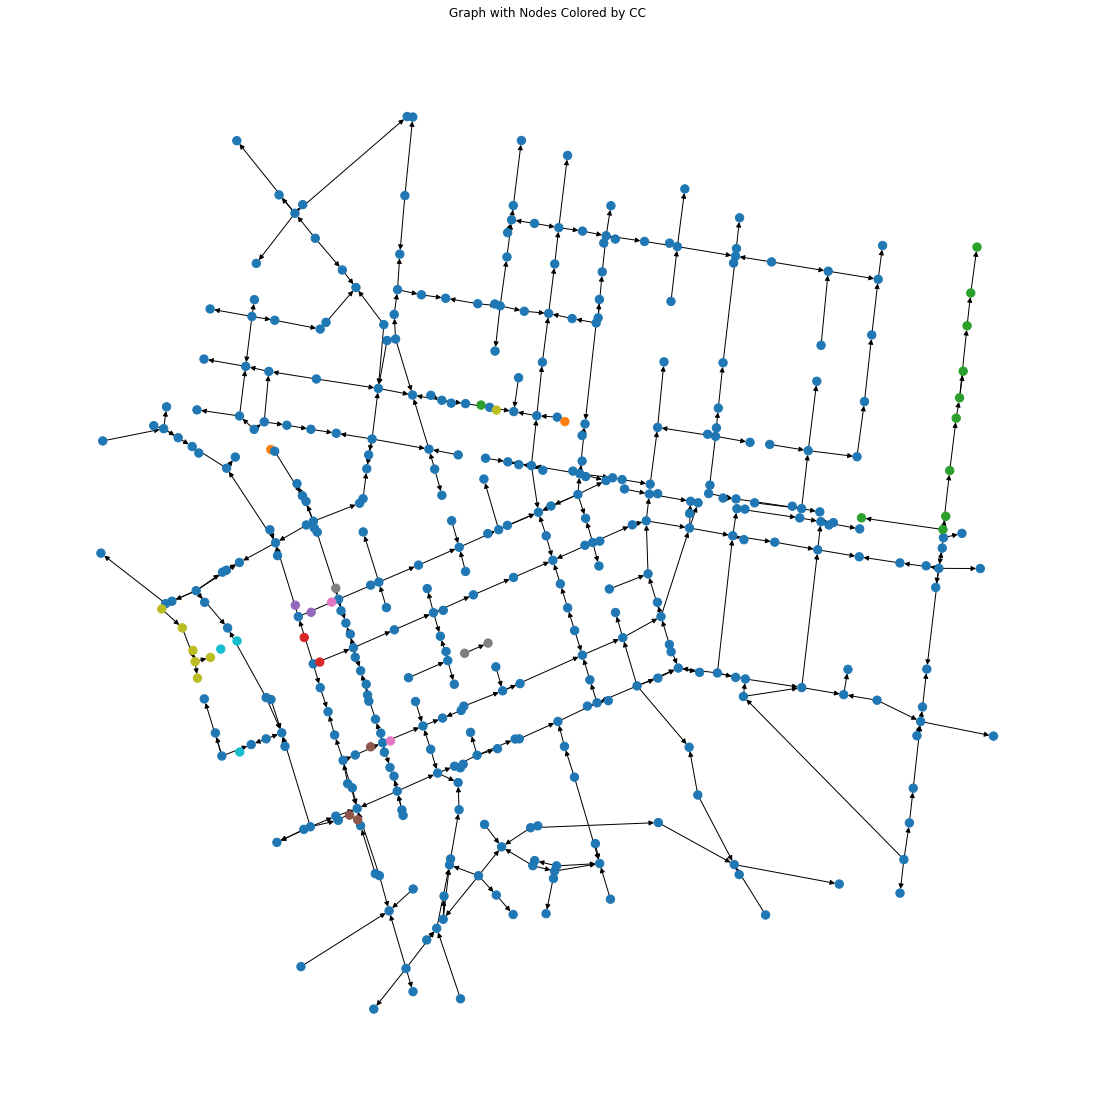

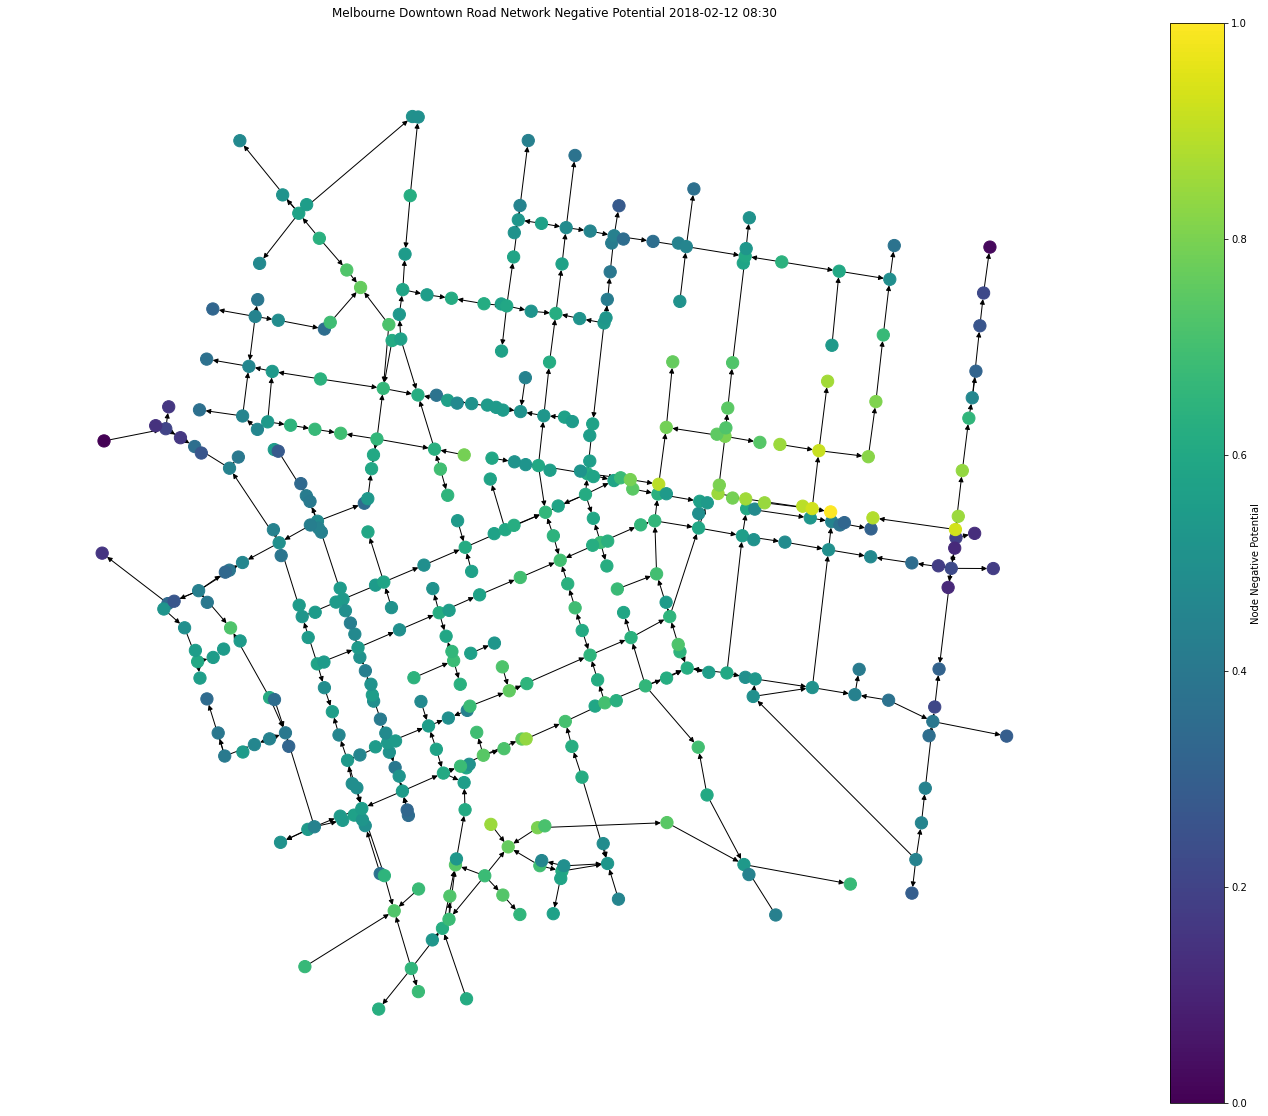

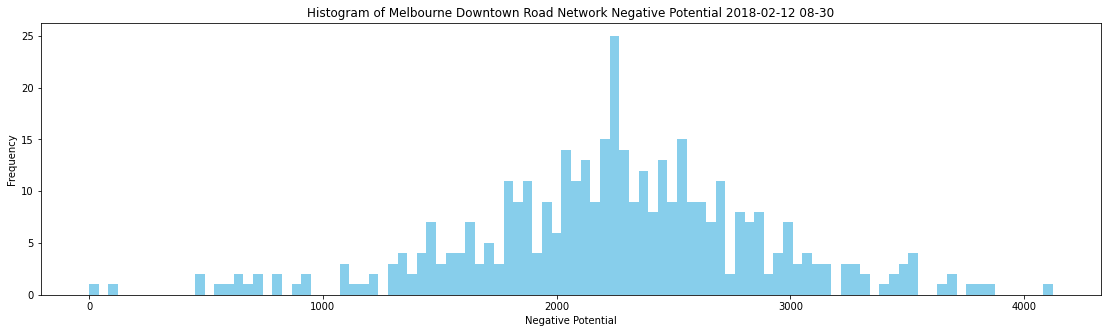

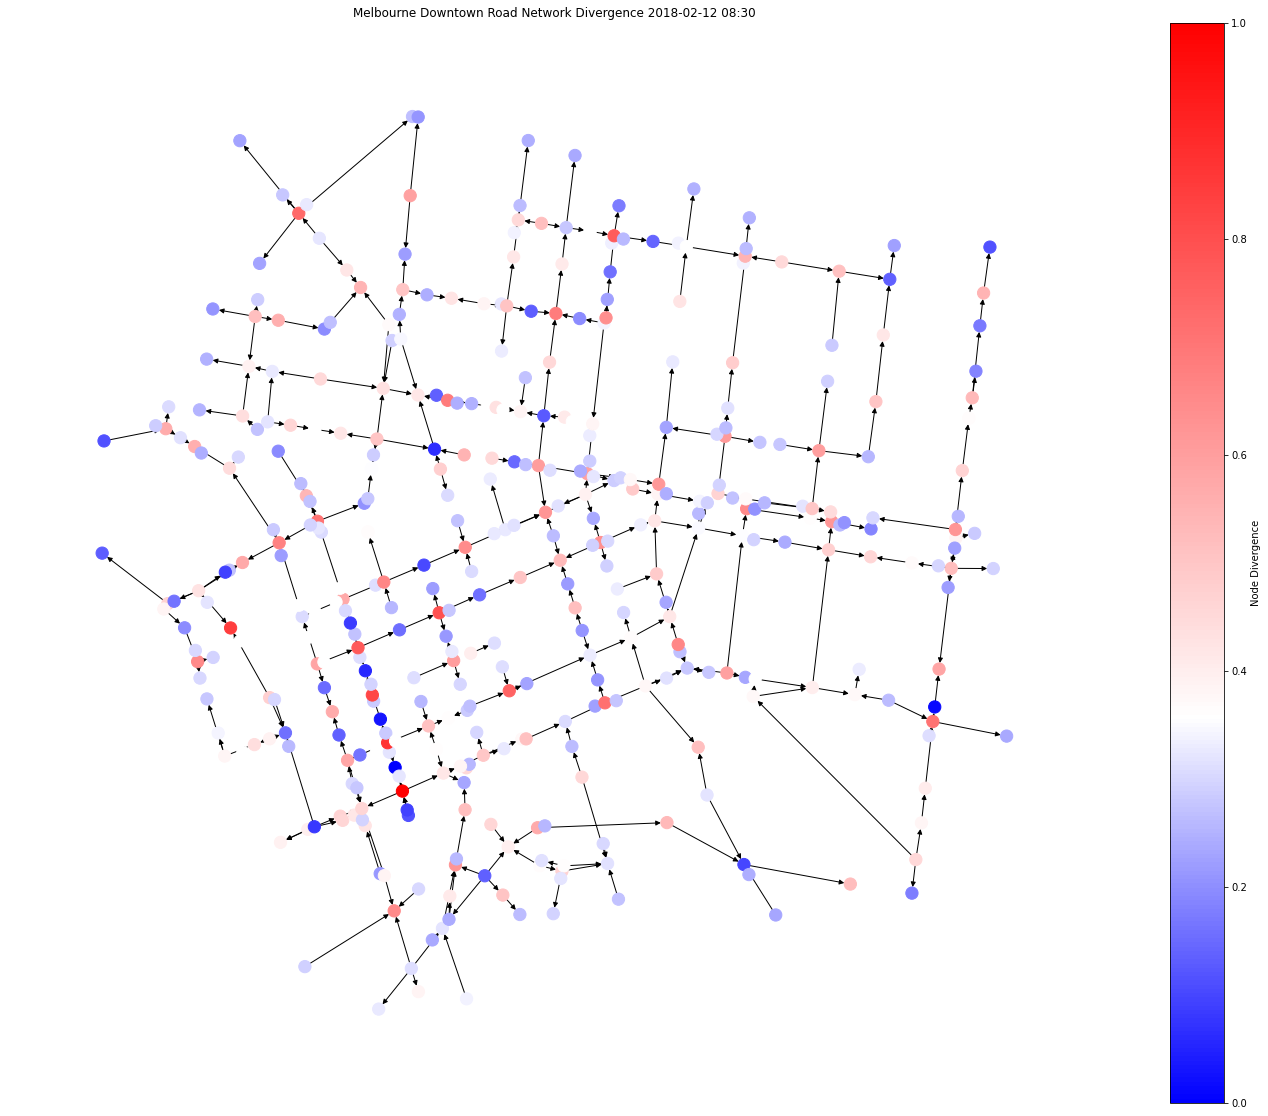

variance value:  (40168800392366.086-2.783862677895634e-05j)


Coefficient of determination:  0.9230509853101455


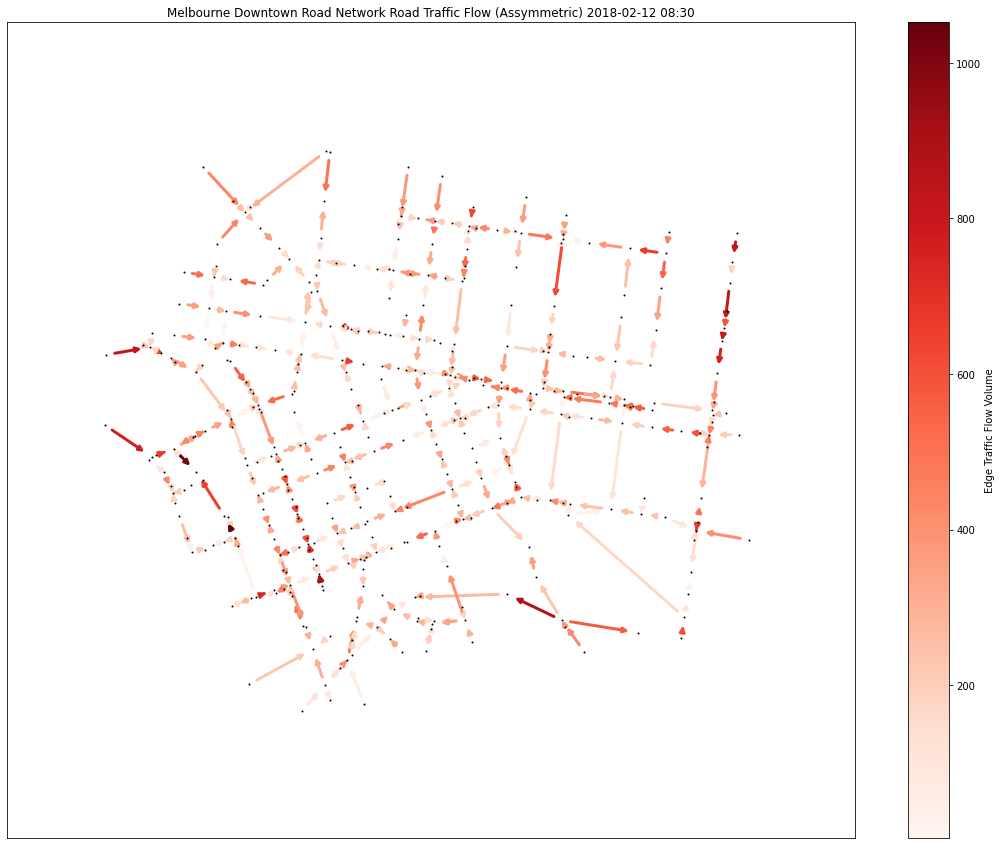

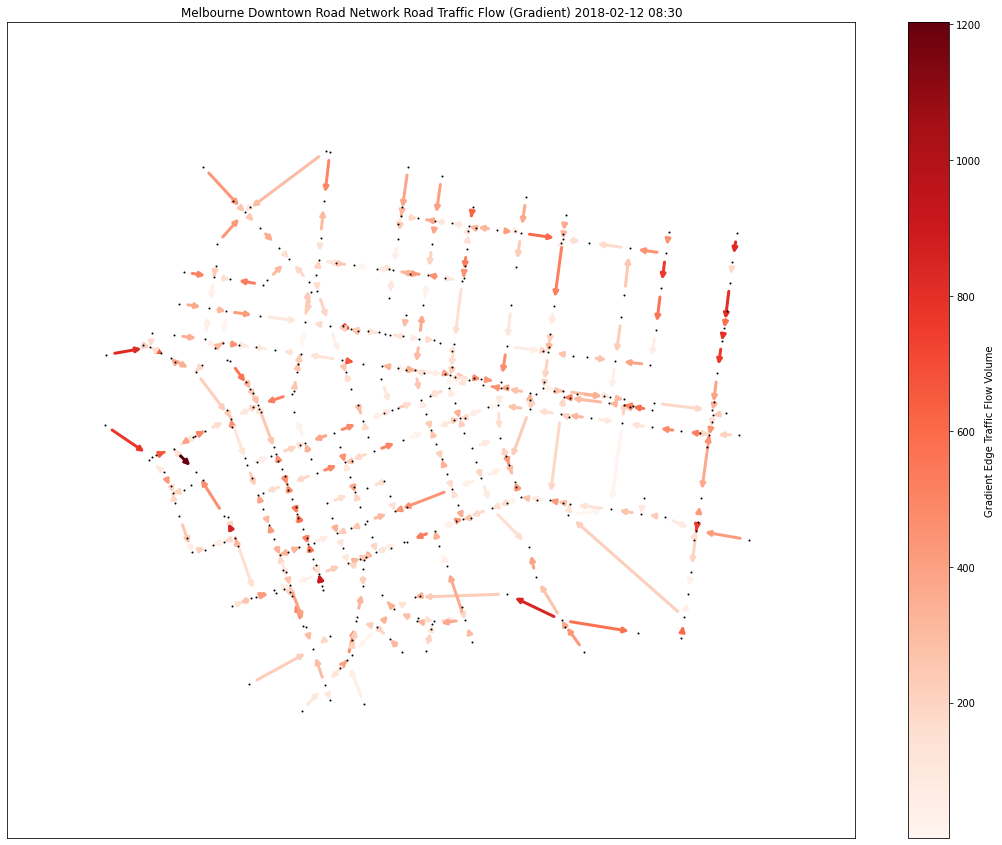

Non-zero percentage of Graph Laplacian:  0.5187032418952618 %


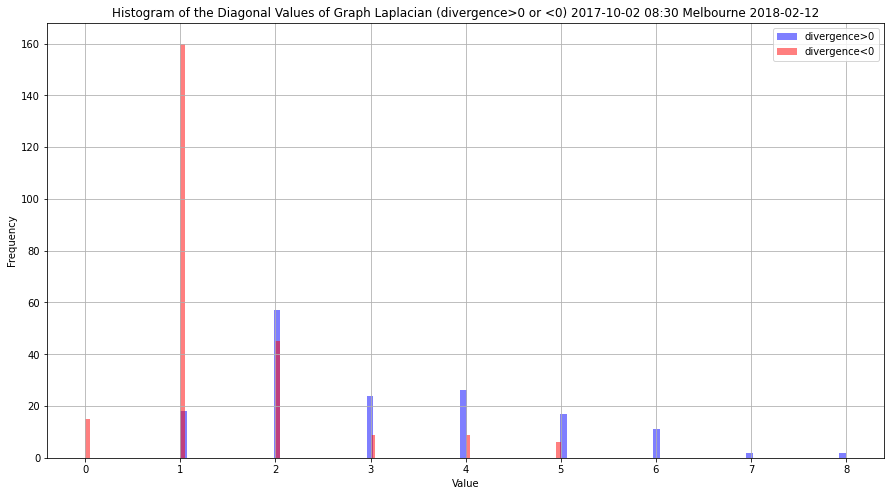

Non-zero percentage of the Inverse of Graph Laplacian:  82.45511221945138 %


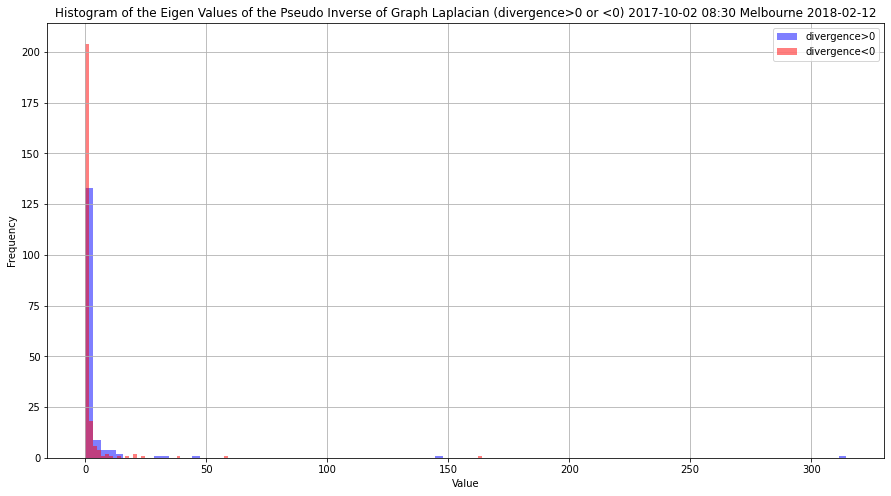

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


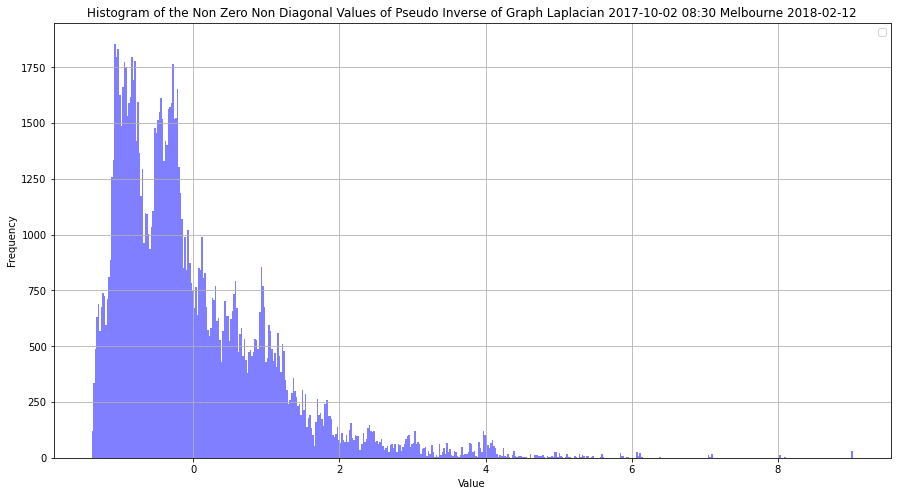

Vertices and Edges Number:  (401, 414)
number of connected components:  21
number of strongly connected components:  401


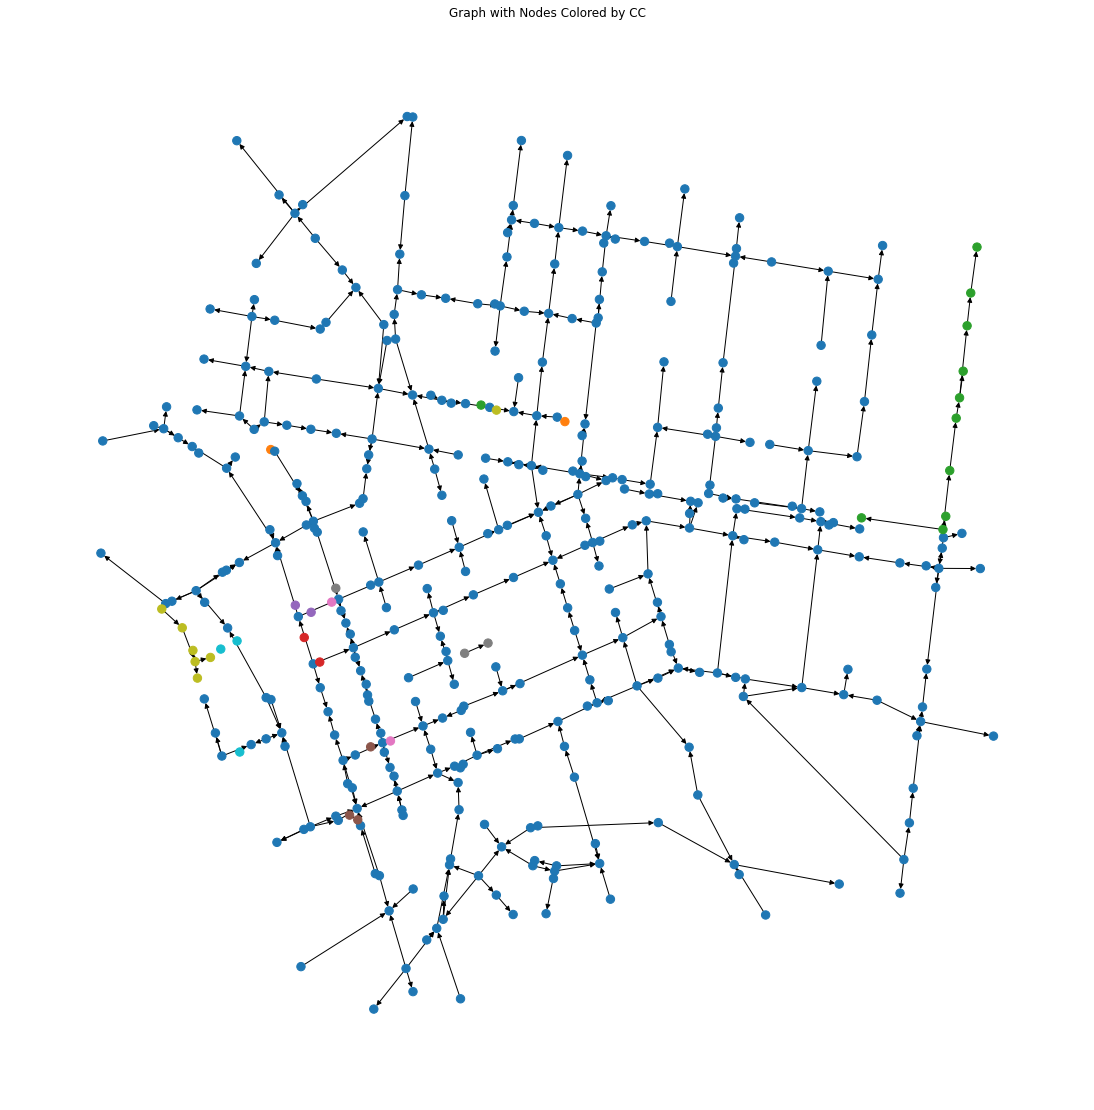

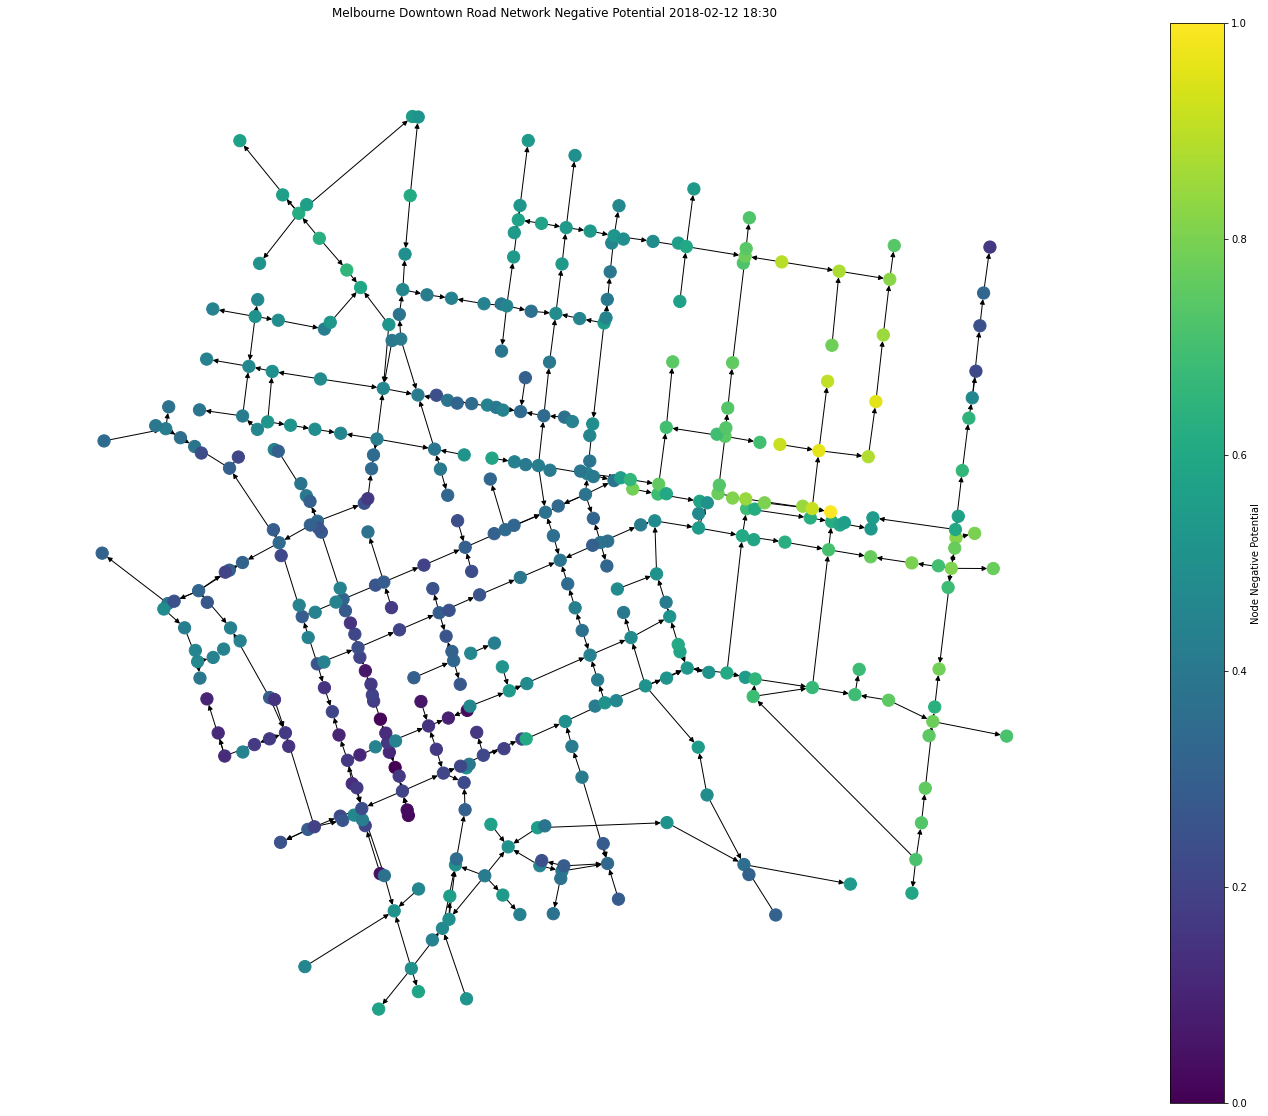

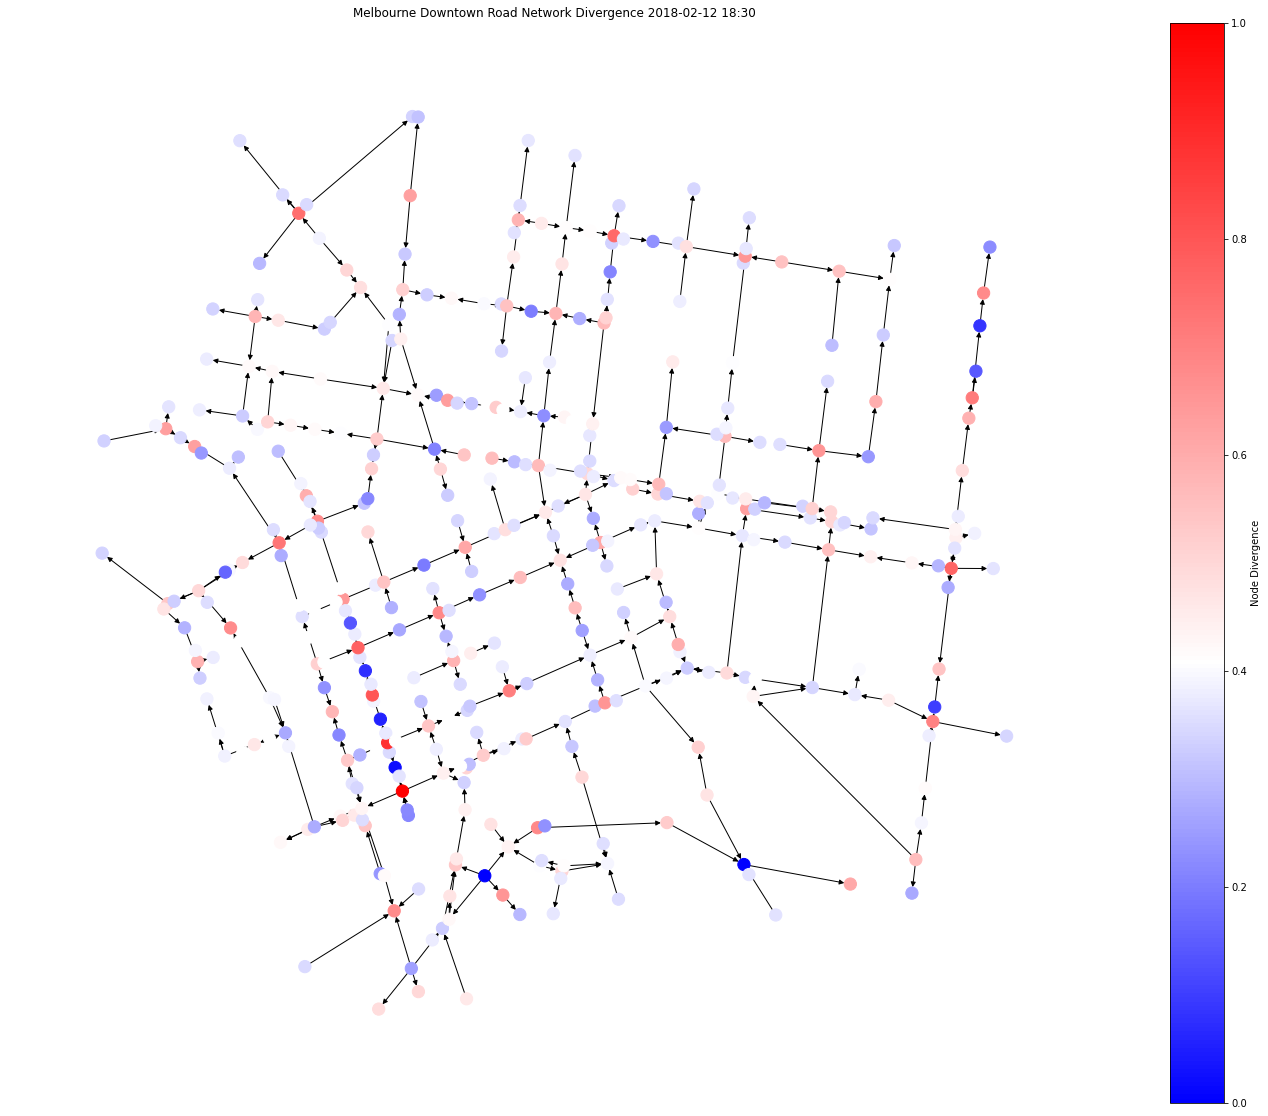

variance value:  (13914855171105.852-7.042367458638364e-06j)


Coefficient of determination:  0.9224461893050826


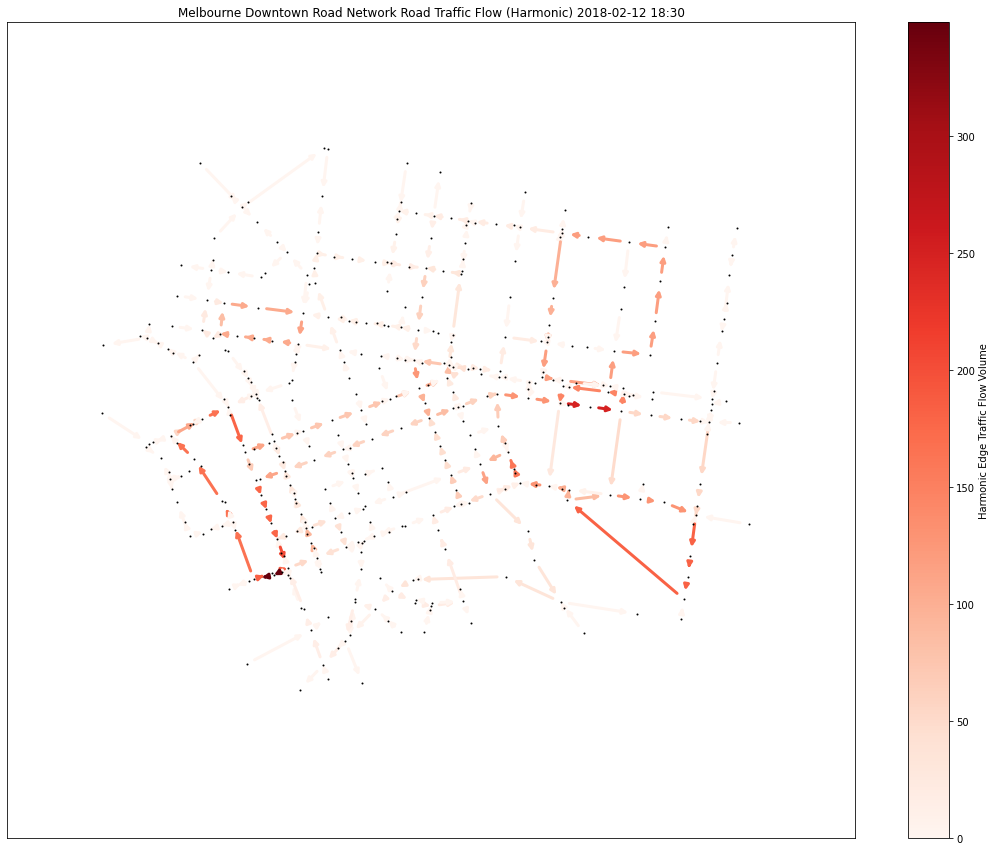

Non-zero percentage of Graph Laplacian:  0.5162094763092269 %


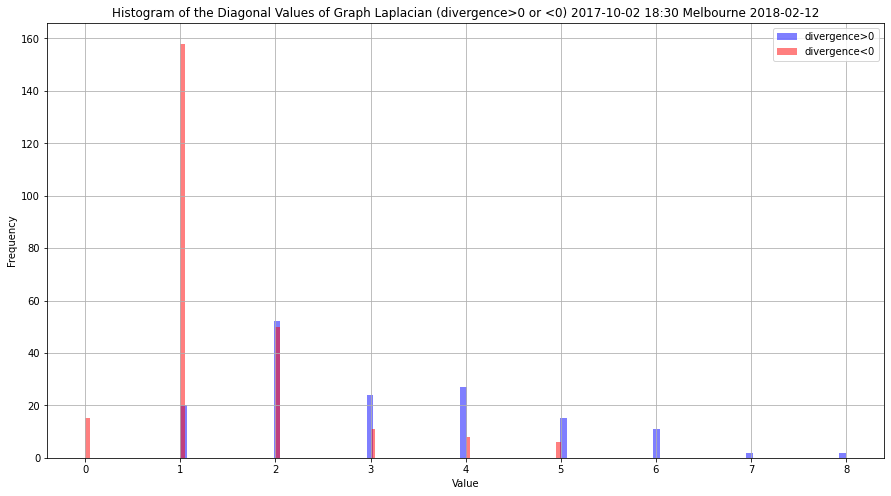

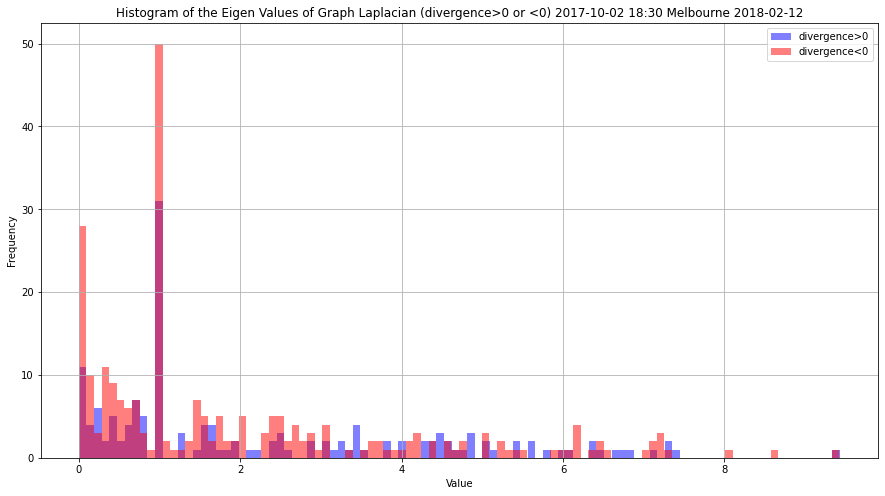

Non-zero percentage of the Inverse of Graph Laplacian:  82.45511221945138 %


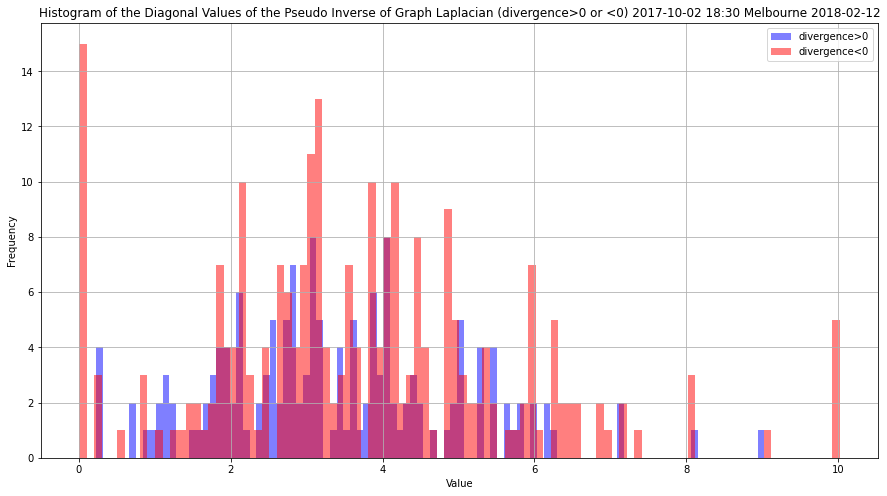

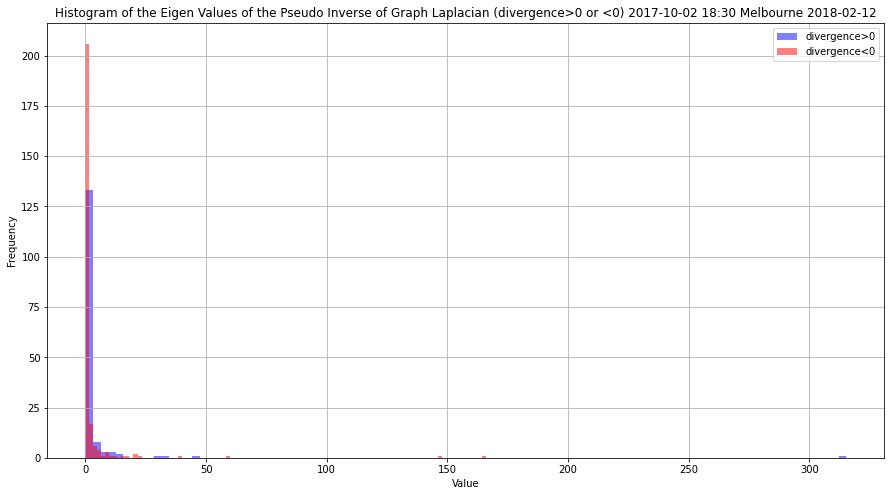

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


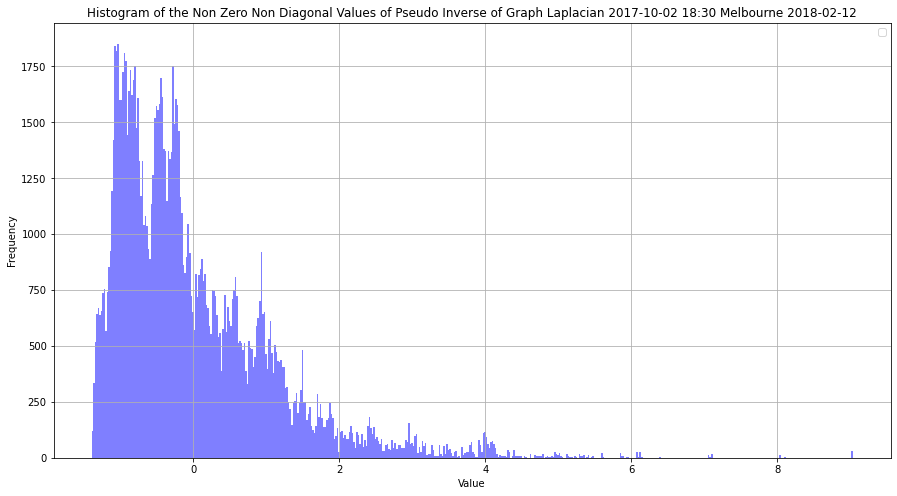

Vertices and Edges Number:  (401, 405)
number of connected components:  26
number of strongly connected components:  401


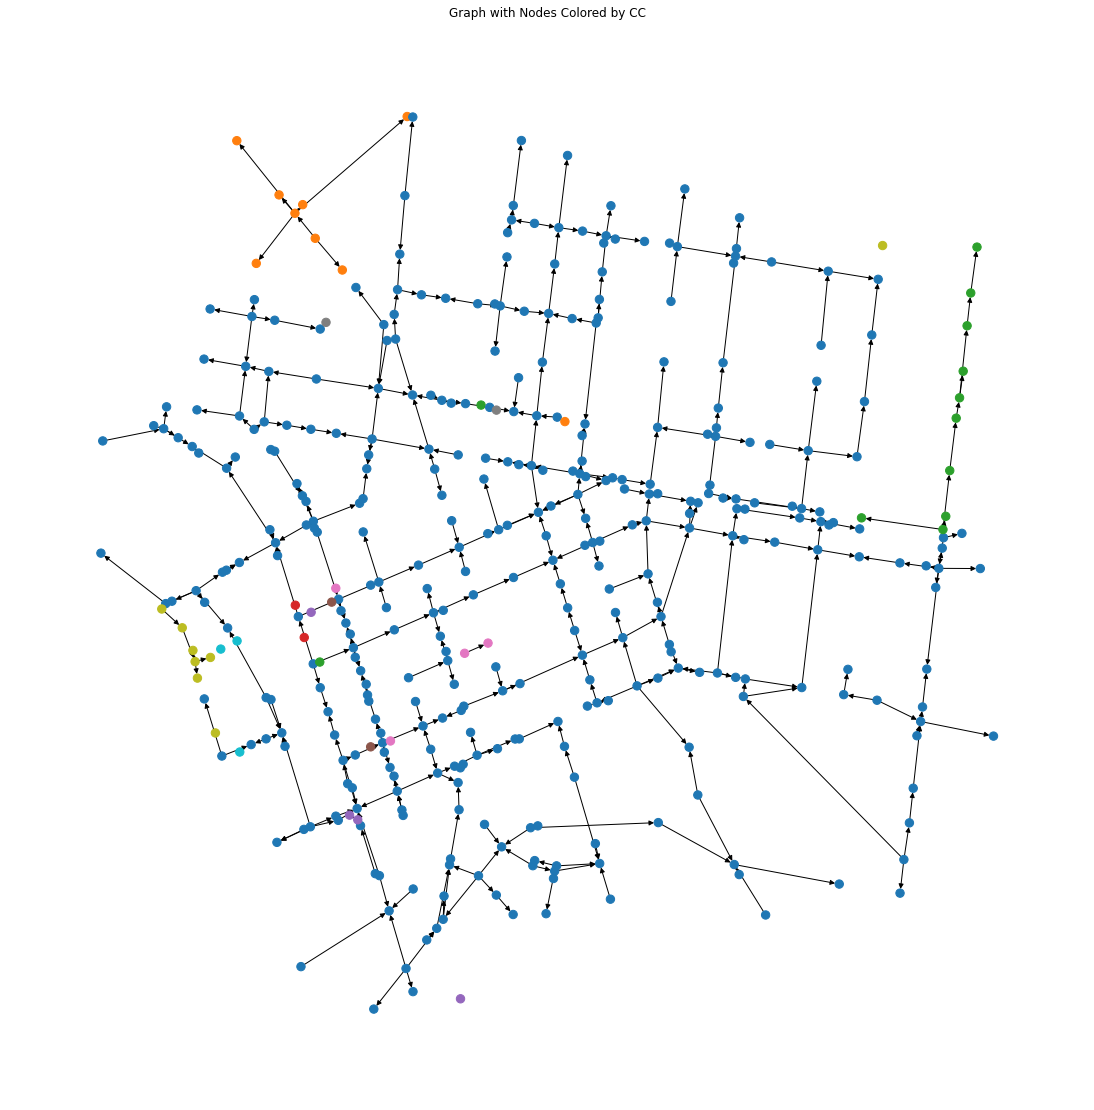

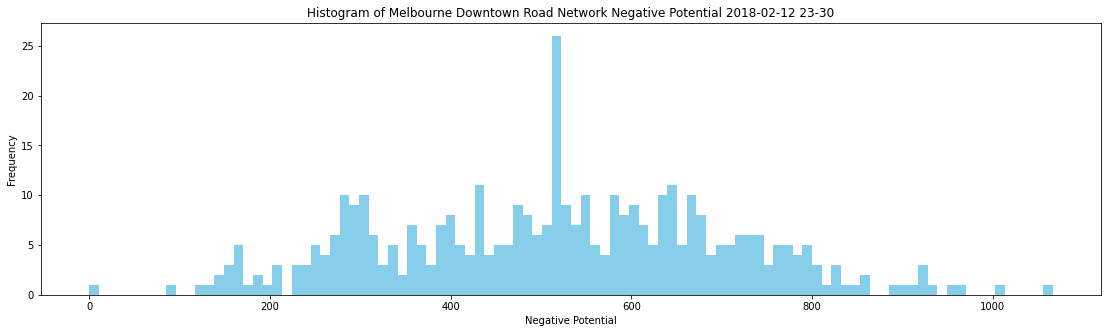

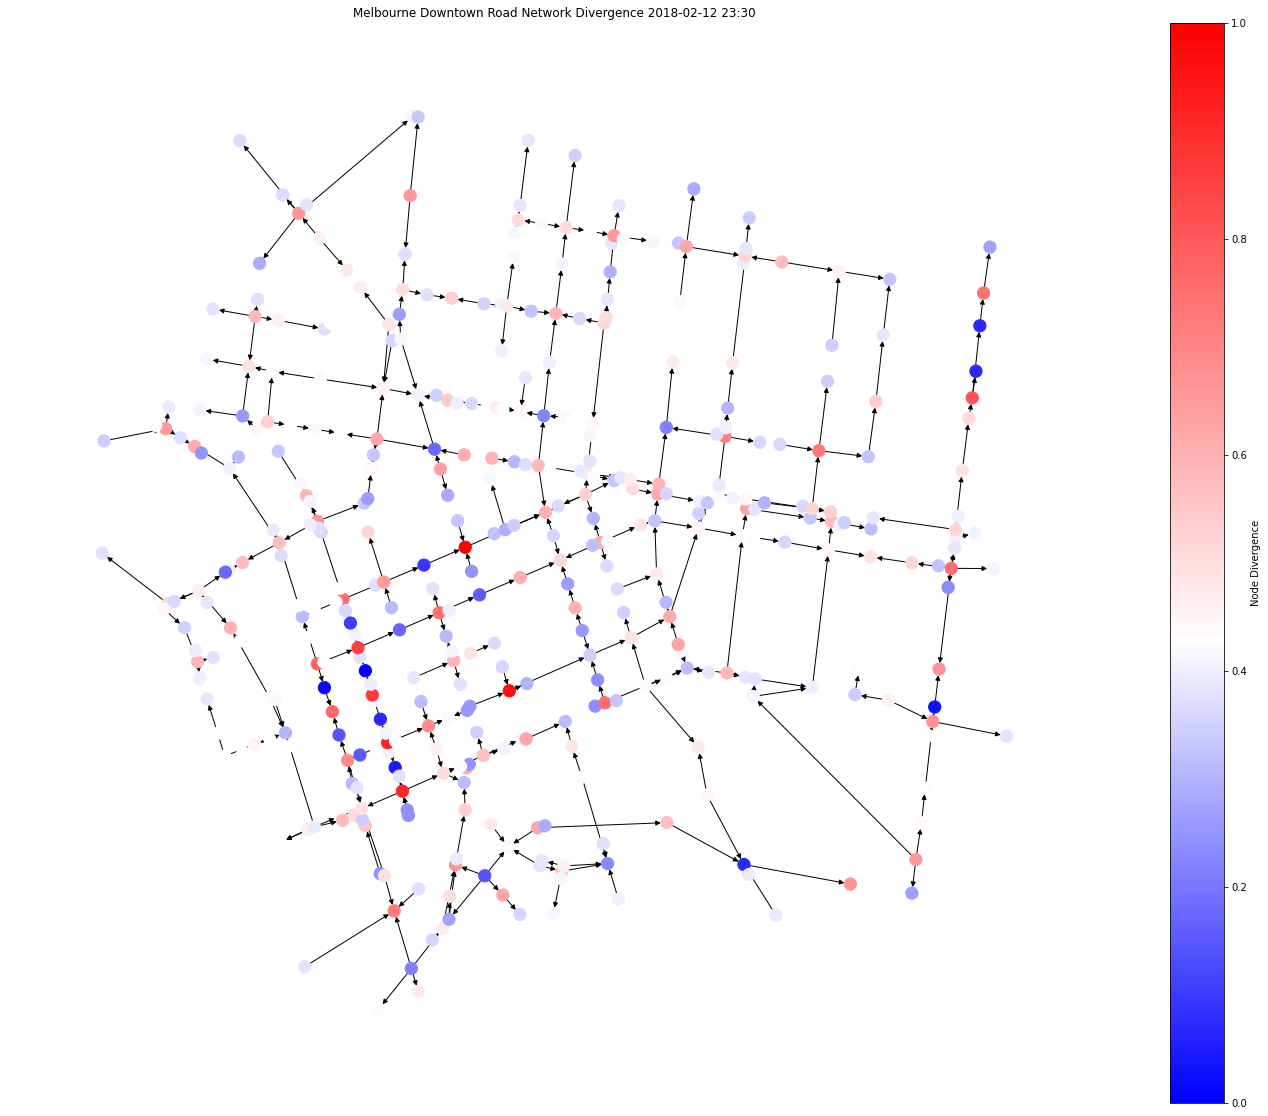

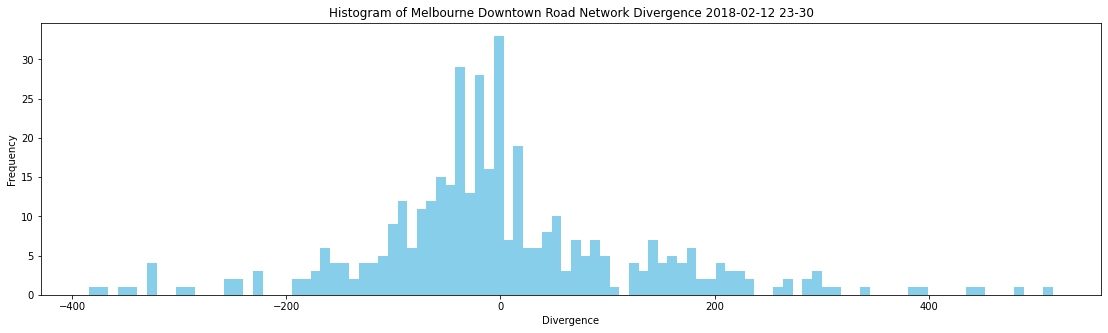

variance value:  (164655291686.37268+1.90989731578278e-07j)


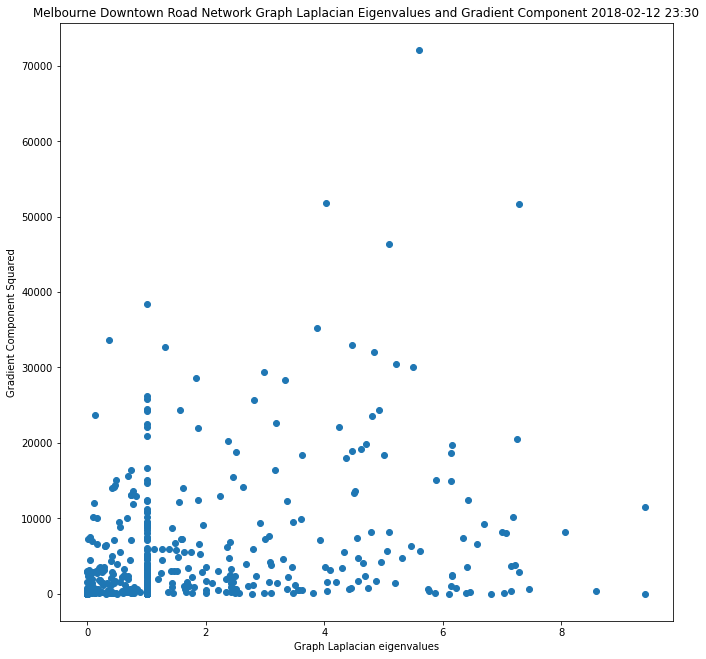

Coefficient of determination:  0.9230925814315714


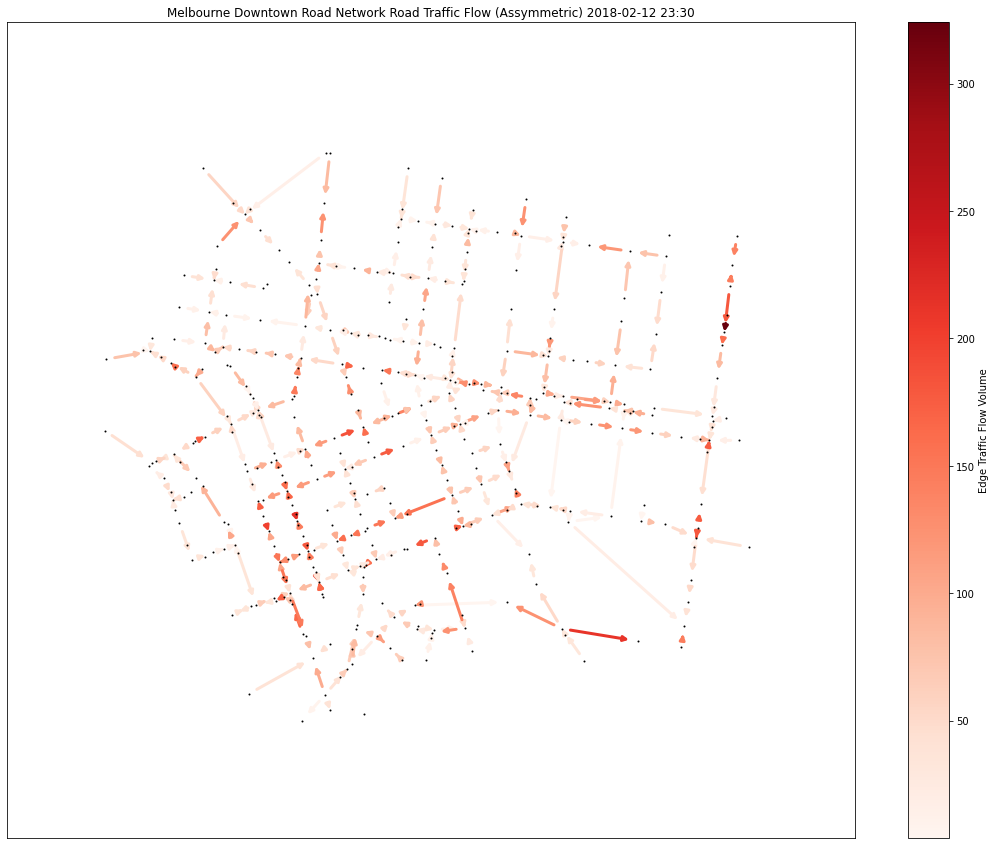

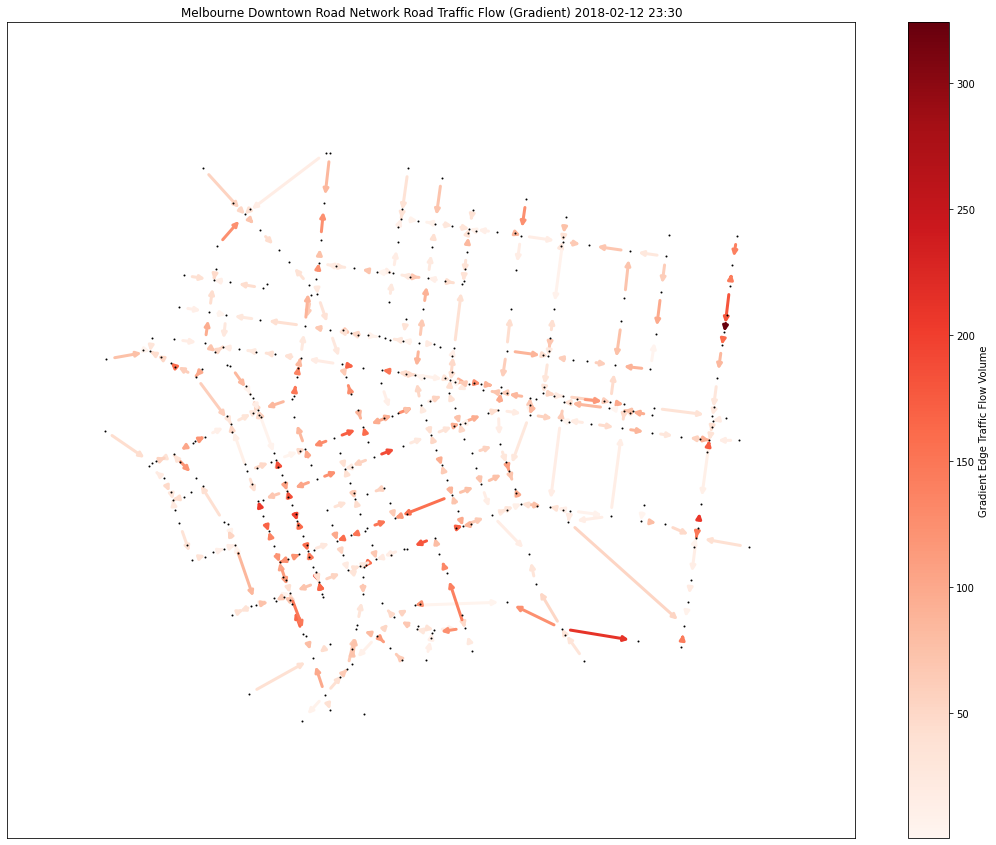

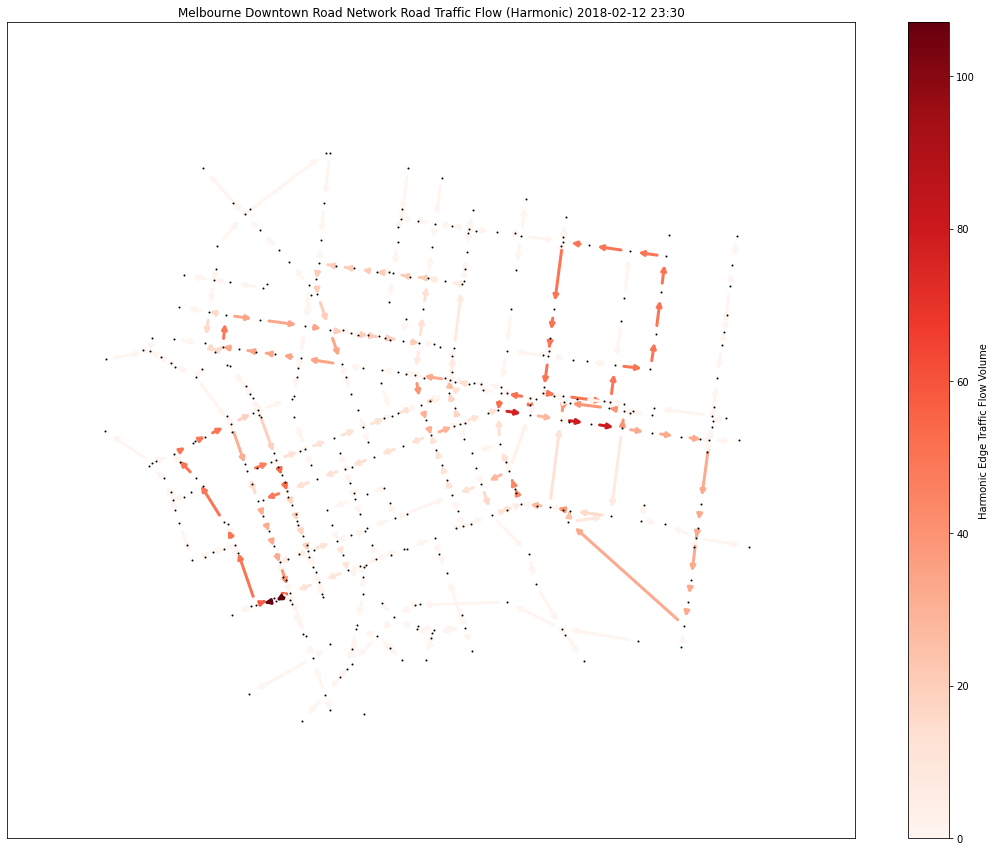

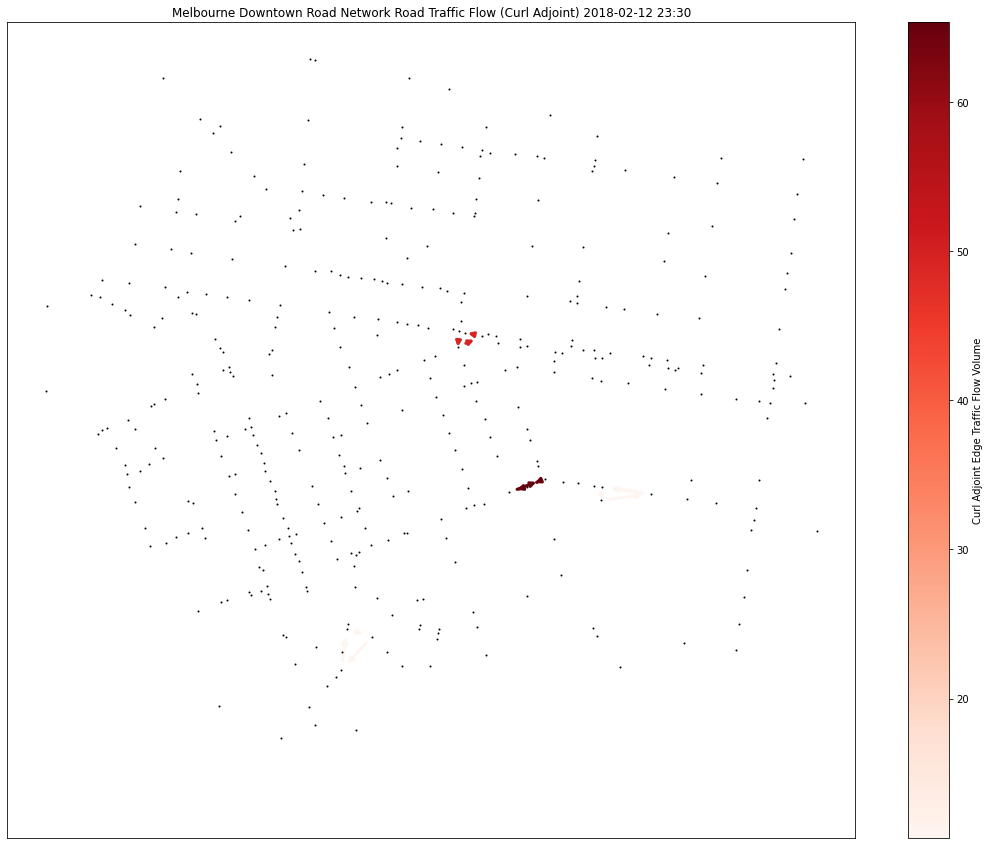

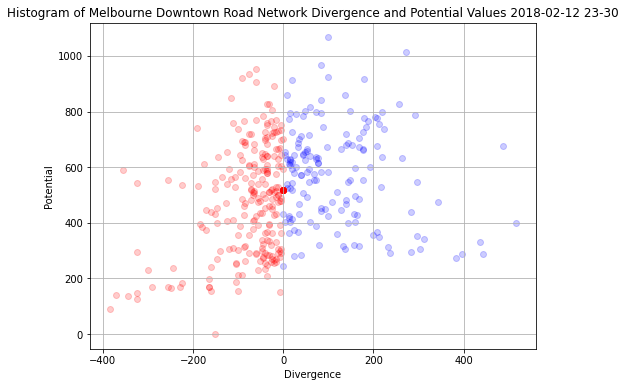

Non-zero percentage of Graph Laplacian:  0.5049875311720698 %


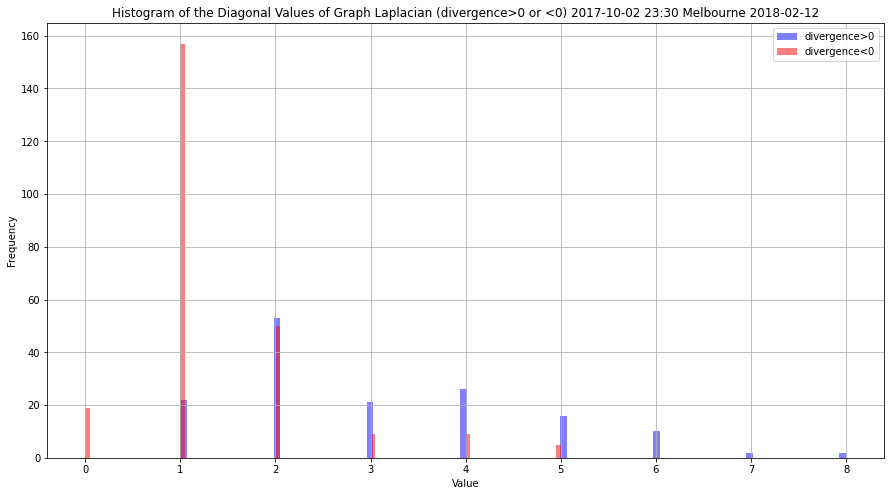

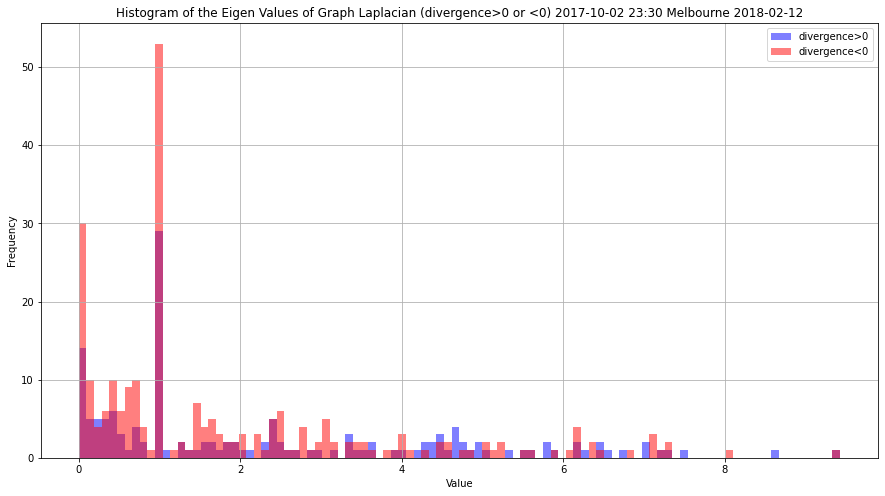

Non-zero percentage of the Inverse of Graph Laplacian:  77.14089775561096 %


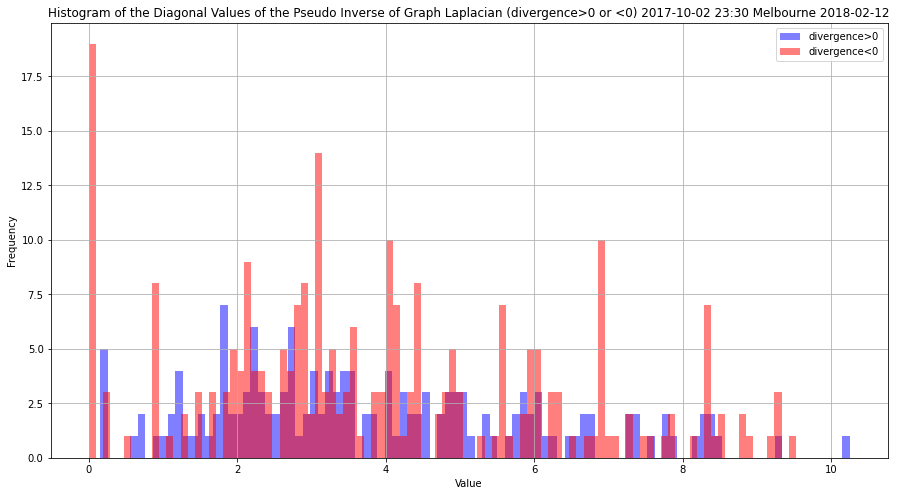

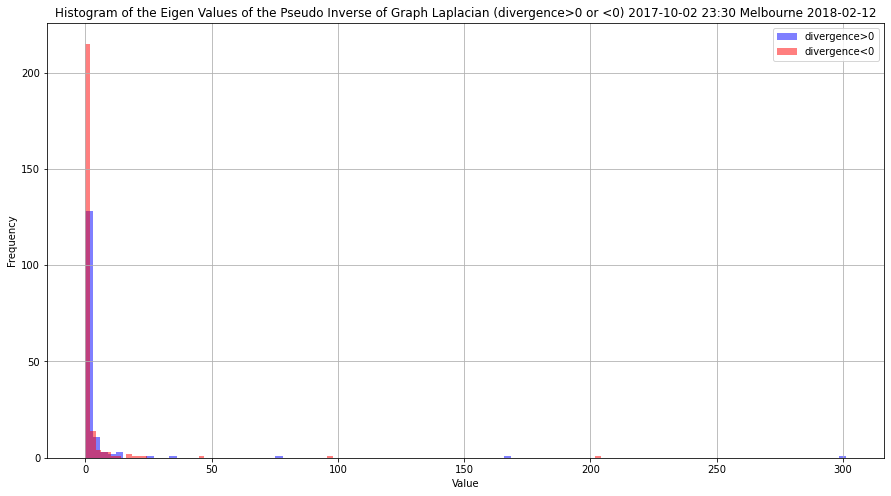

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


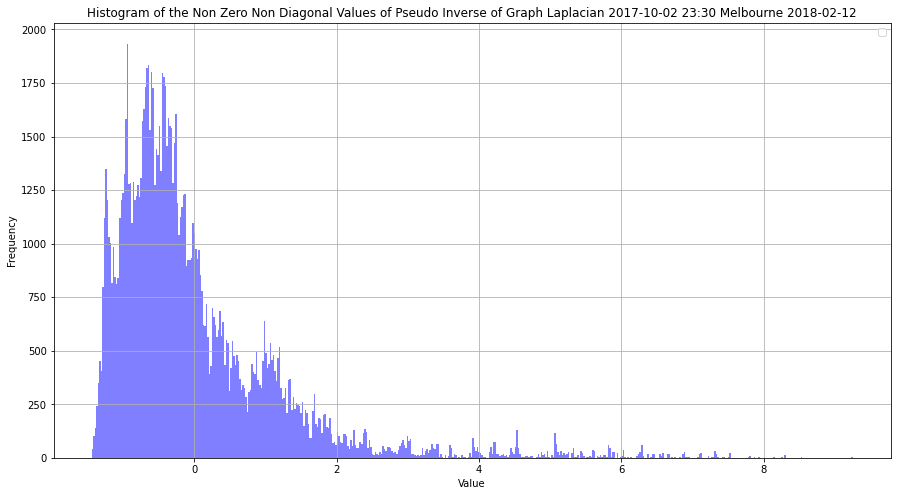

In [36]:
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

for hour in ["03","08","18","23"]:
    for minute in ["30"]:
        city = "Melbourne"
        day = "2018-02-12"
        df_1 = df[df["time"]==f"{hour}:{minute}"]
        nodes = df_nodes.index
        edge_dict = dict(zip([tuple(json.loads(i)) for i in df_1["cluster"]],df_1["real_flow"]))
        three_components, four_matrices, (vertices_potential,vertices_divergence,triangles_curl), (vertices,edges,triangles), internal_nodes_dict, edge_flows,G = \
            get_graph_hodge_decomposition(nodes,edge_dict)
        gradient_component,graph_helmholtzian_kernel_component,curl_adjoint_component = three_components
        vertex_by_edge_boundary,graph_laplacian,graph_helmholtzian,edge_by_triangle_boundary = four_matrices
        print("Vertices and Edges Number: ",vertex_by_edge_boundary.shape)
        potential_divergence_map(G, vertices_potential,vertices_divergence,hour,minute, city, day)
        eigenvalue_gradient_component_map(graph_laplacian.toarray(),vertex_by_edge_boundary.toarray(),gradient_component,hour,minute, city, day)
        draw_Edge_flow(nodes,edge_dict,edges,edge_flows,gradient_component,graph_helmholtzian_kernel_component,curl_adjoint_component,hour,minute, city, day)
        plot_urban_divergence_potential(vertices_potential, vertices_divergence,hour,minute, city, day)
        draw_matrix_values(graph_laplacian.toarray(), vertices_divergence,hour,minute,city,day)

In [37]:
def get_urban_divergence_potential(nodes,edge_dict):
    G, internal_nodes_dict = build_graph(nodes,edge_dict)
    edge_flows = np.array([data['weight'] for _, _, data in G.edges(data=True)]).T
    vertex_by_edge_boundary,vertices,edges = get_vertex_by_edge_boundary(G)
    vertices_potential = lsqr(vertex_by_edge_boundary.T, edge_flows)[0]
    vertices_potential = vertices_potential-min(vertices_potential)
    graph_laplacian = get_graph_laplacian(G)
    vertices_divergence = graph_laplacian@vertices_potential
    return vertices_potential,vertices_divergence,graph_laplacian, vertex_by_edge_boundary,edge_flows

In [41]:
from datetime import datetime

def plot_variance(city,date):
    times = []
    potential_variances = []
    divergence_variances = []
    potential_vars = []
    divergence_vars = []
    for i in ["00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19",
            "20","21","22","23"]:
        for j in ["00","15","30","45"]:
            df_1 = df[df["time"]==f"{i}:{j}"]
            nodes = df_nodes.index
            vertex_num = len(nodes)
            edge_dict = dict(zip([tuple(json.loads(i)) for i in df_1["cluster"]],df_1["real_flow"]))
            vertices_potential,vertices_divergence,graph_laplacian,vertex_by_edge_boundary,edge_flows = get_urban_divergence_potential(nodes,edge_dict)
            potential_variance = get_local_relative_variance(graph_laplacian.toarray(),vertices_potential)
            divergence_variance = get_local_relative_variance(graph_laplacian.toarray(),vertices_divergence)
            potential_variances.append(potential_variance)
            divergence_variances.append(divergence_variance)
            potential_vars.append((vertex_num-1)*np.var(vertices_potential))
            divergence_vars.append((vertex_num-1)*np.var(vertices_divergence))
            times.append(datetime.strptime(f'{date} {i}:{j}', '%Y-%m-%d %H:%M'))
    plt.figure(figsize=(20, 10))
    plt.scatter(times, potential_vars, marker='o', label='global poential variance',alpha=0.85, c="red")
    plt.scatter(times, divergence_vars, marker='o', label='global divergence variance',alpha=0.85, c="blue")
    plt.scatter(times, potential_variances, marker='o', label='local poential variance',alpha=0.85, c="green")
    plt.scatter(times, divergence_variances, marker='o', label='local divergence variance',alpha=0.85, c="orange")
    plt.xlabel('Time')
    plt.ylabel('Variances')
    plt.title(f'Local and Global Potential Divergence Variances Scatter Plot {date} {city}')
    plt.legend()
    plt.grid(True)
    plt.show()

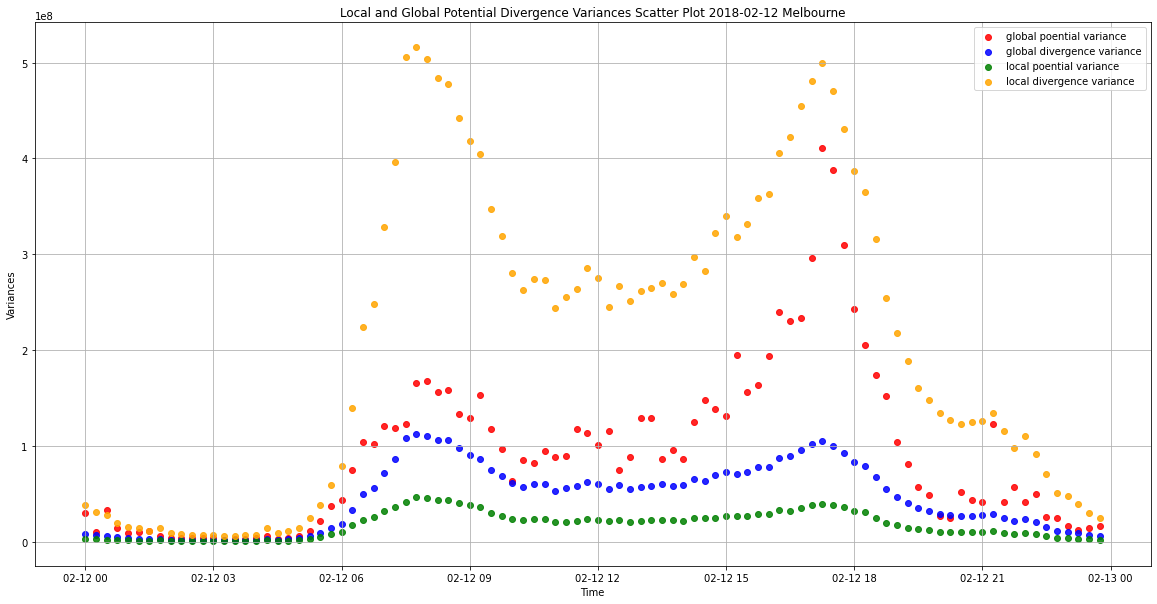

In [42]:
plot_variance("Melbourne","2018-02-12")

In [43]:
from datetime import datetime

def plot_variance_ratio(city,date):
    times = []
    potential_variances = []
    divergence_variances = []
    potential_vars = []
    divergence_vars = []
    for i in ["00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19",
            "20","21","22","23"]:
        for j in ["00","15","30","45"]:
            df_1 = df[df["time"]==f"{i}:{j}"]
            nodes = df_nodes.index
            vertex_num = len(nodes)
            edge_dict = dict(zip([tuple(json.loads(i)) for i in df_1["cluster"]],df_1["real_flow"]))
            vertices_potential,vertices_divergence,graph_laplacian,vertex_by_edge_boundary,edge_flows = get_urban_divergence_potential(nodes,edge_dict)
            potential_variance = get_local_relative_variance(graph_laplacian.toarray(),vertices_potential)
            divergence_variance = get_local_relative_variance(graph_laplacian.toarray(),vertices_divergence)
            potential_variances.append(potential_variance)
            divergence_variances.append(divergence_variance)
            potential_vars.append((vertex_num-1)*np.var(vertices_potential))
            divergence_vars.append((vertex_num-1)*np.var(vertices_divergence))
            times.append(datetime.strptime(f'{date} {i}:{j}', '%Y-%m-%d %H:%M'))
    plt.figure(figsize=(20, 10))
    plt.scatter(times, np.array(divergence_variances)/np.array(potential_vars), marker='o', label='local divergence variance/global poential variance',alpha=0.85, c="orange")
    plt.scatter(times, np.array(divergence_variances)/np.array(divergence_vars), marker='o', label='local divergence variance/global divergence variance',alpha=0.85, c="blue")
    plt.scatter(times, np.array(divergence_variances)/np.array(potential_variances), marker='o', label='local divergence variance/local poential variance',alpha=0.85, c="green")
    plt.scatter(times, np.array(potential_vars)/np.array(potential_variances), marker='o', label='global poential variance/local poential variance',alpha=0.85, c="red")
    plt.scatter(times, np.array(potential_vars)/np.array(divergence_vars), marker='o', label='global poential variance/global divergence variance',alpha=0.85, c="purple")
    plt.scatter(times, np.array(divergence_vars)/np.array(potential_variances), marker='o', label='global divergence variance/local poential variance',alpha=0.85, c="pink")
    plt.xlabel('Time')
    plt.ylabel('Variances Ratio')
    plt.title(f'Local and Global Potential Divergence Variances Ratio Scatter Plot {date} {city}')
    plt.legend()
    plt.grid(True)
    plt.show()

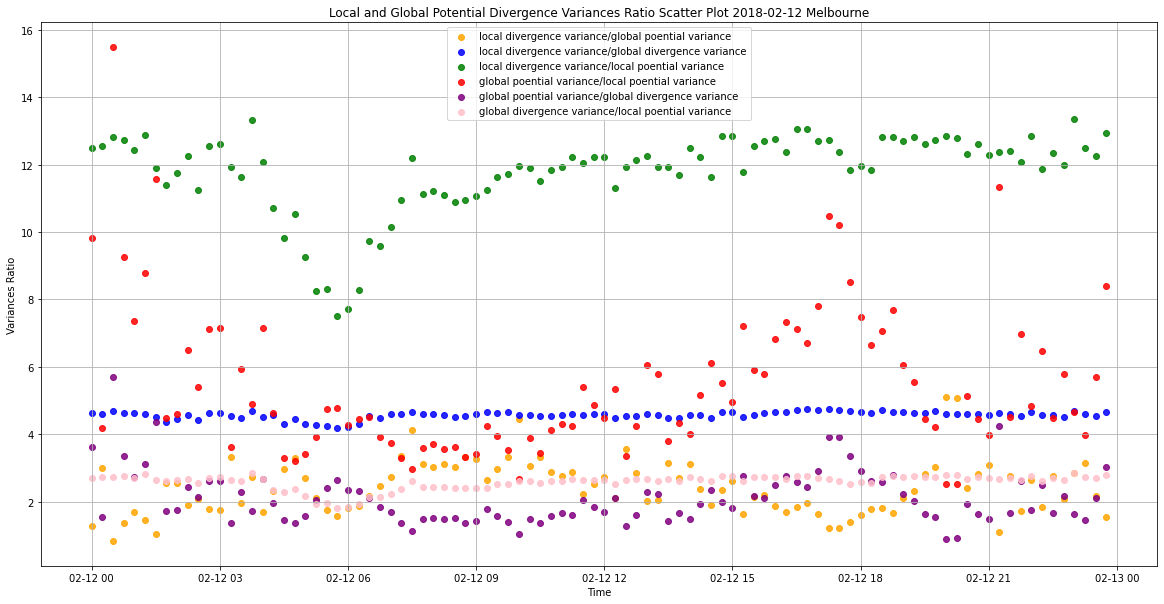

In [44]:
plot_variance_ratio("Melbourne","2018-02-12")

In [46]:
def assortativity(incidence_matrix, vector):
    pos_inc_mat = incidence_matrix.copy()
    pos_inc_mat[pos_inc_mat==-1] = 0
    neg_inc_mat = incidence_matrix.copy()
    neg_inc_mat[neg_inc_mat==1] = 0
    cen_mat = np.eye(incidence_matrix.shape[0])-np.ones([incidence_matrix.shape[0],incidence_matrix.shape[0]])/incidence_matrix.shape[0]
    numerator = vector.T@pos_inc_mat.T@cen_mat@neg_inc_mat@vector
    denominator = (vector.T@pos_inc_mat.T@cen_mat@pos_inc_mat@vector@vector.T@neg_inc_mat.T@cen_mat@neg_inc_mat@vector)**(1/2)
    return -numerator/denominator[[0]]

def plot_assortativity(city,date):
    times = []
    potential_assorts = []
    divergence_assorts = []
    for i in ["00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19",
            "20","21","22","23"]:
        for j in ["00","15","30","45"]:
            df_1 = df[df["time"]==f"{i}:{j}"]
            nodes = df_nodes.index
            vertex_num = len(nodes)
            edge_dict = dict(zip([tuple(json.loads(i)) for i in df_1["cluster"]],df_1["real_flow"]))
            vertices_potential,vertices_divergence,graph_laplacian,vertex_by_edge_boundary,edge_flows = get_urban_divergence_potential(nodes,edge_dict)
            potential_assort = assortativity(vertex_by_edge_boundary.T,vertices_potential.reshape(-1,1))
            divergence_assort = assortativity(vertex_by_edge_boundary.T,vertices_divergence.reshape(-1,1))
            potential_assorts.append(potential_assort)
            divergence_assorts.append(divergence_assort)
            times.append(datetime.strptime(f'{date} {i}:{j}', '%Y-%m-%d %H:%M'))
    plt.figure(figsize=(20, 10))
    plt.scatter(times, divergence_assorts, marker='o', label='divergence assortativity',alpha=0.85, c="blue")
    plt.scatter(times, potential_assorts, marker='o', label='poential assortativity',alpha=0.85, c="red")
    plt.xlabel('Time')
    plt.ylabel('Assortativity')
    plt.title(f'Potential and Divergence Assortativity Scatter Plot {date} {city}')
    plt.legend()
    plt.grid(True)
    plt.show()

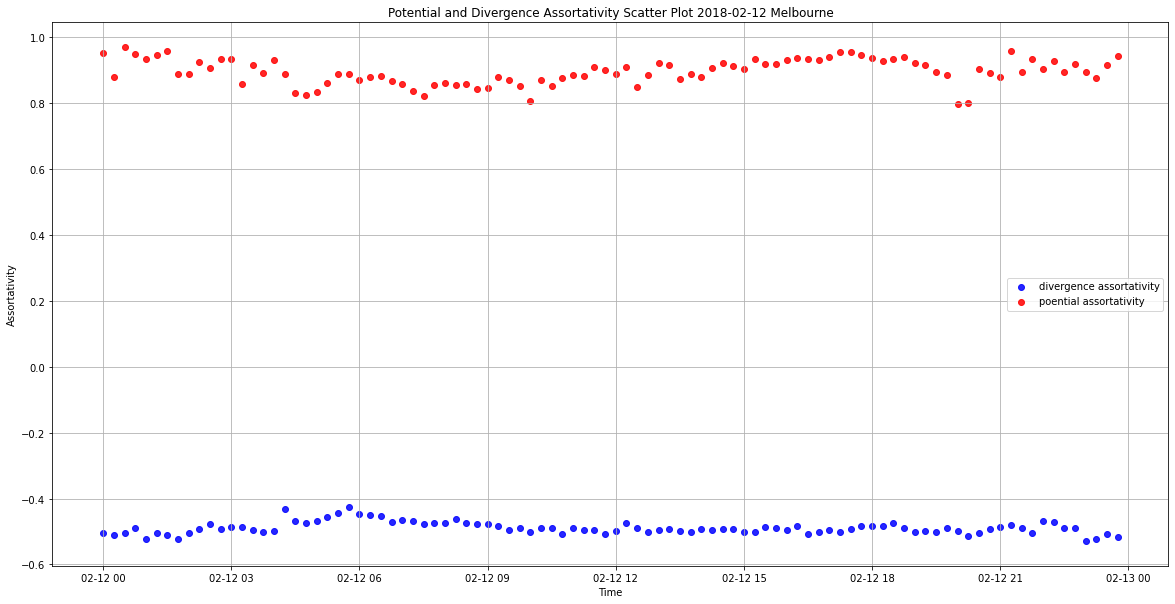

In [47]:
plot_assortativity("Melbourne","2018-02-12")

In [48]:
def plot_coeff(city,date):
    times = []
    coeffs = []
    for i in ["00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19",
            "20","21","22","23"]:
        for j in ["00","15","30","45"]:
            df_1 = df[df["time"]==f"{i}:{j}"]
            nodes = df_nodes.index
            edge_dict = dict(zip([tuple(json.loads(i)) for i in df_1["cluster"]],df_1["real_flow"]))
            vertices_potential,vertices_divergence,graph_laplacian,vertex_by_edge_boundary,edge_flows = get_urban_divergence_potential(nodes,edge_dict)
            gradient_component = vertex_by_edge_boundary.T@vertices_potential
            coeff = np.sum(gradient_component**2)/np.sum(edge_flows**2)
            coeffs.append(coeff)
            times.append(datetime.strptime(f'{date} {i}:{j}', '%Y-%m-%d %H:%M'))
    plt.figure(figsize=(20, 10))
    plt.scatter(times, coeffs, marker='o', label='Coefficient of Determination',alpha=0.85, c="blue")
    plt.xlabel('Time')
    plt.ylabel('Coefficient of Determination')
    plt.title(f'Coefficient of Determination Scatter Plot {date} {city}')
    plt.legend()
    plt.grid(True)
    plt.show()

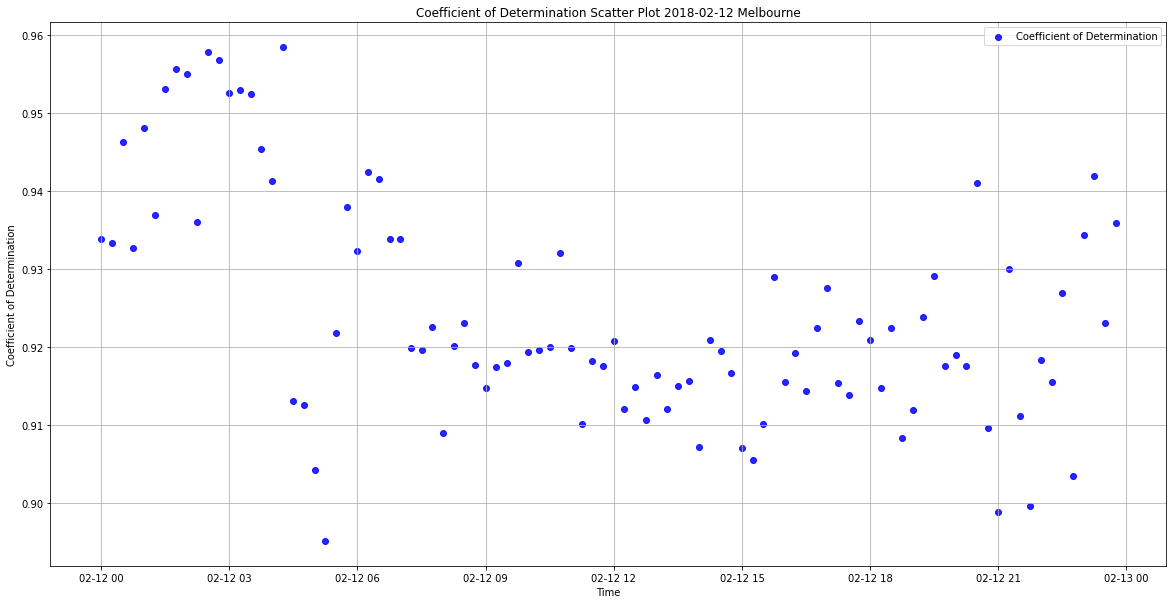

In [49]:
plot_coeff("Melbourne","2018-02-12")